In [204]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

## Functions

In [265]:
# def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
#     """
#     Estimate amplitude by detecting peaks and computing average peak height.

#     Parameters:
#     - signal: 1D numpy array
#     - height, distance, prominence: Optional arguments for peak detection

#     Returns:
#     - amplitude: Estimated amplitude
#     - peak_values: Values of detected peaks
#     - trough_values: Values of detected troughs
#     """
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

#     peak_values = signal[peaks]
#     trough_values = signal[troughs]

#     if len(peak_values) == 0 or len(trough_values) == 0:
#         return None, peak_values, trough_values  # Not enough data

#     avg_peak = np.mean(peak_values)
#     avg_trough = np.mean(trough_values)
 
#     amplitude = 0.5 * (avg_peak - avg_trough)
#     amplitude = np.nan_to_num(amplitude, nan=0.0)  # Handle NaN values
#     return amplitude, peak_values, trough_values

def estimate_amplitude_from_peaks(signal, height=None, distance=5000, prominence=None):
    """
    Estimate the amplitude of an oscillating signal using peak and trough detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, automatically ignore first peak/trough if it's a large outlier

    Returns:
    - amplitude: Estimated average amplitude (float)
    - peak_indices: Indices of the used peaks
    - trough_indices: Indices of the used troughs
    """
    peak_indices, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    trough_indices, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    if len(peak_indices) < 1 or len(trough_indices) < 1:
        return None, peak_indices, trough_indices

    peak_vals = signal[peak_indices]
    trough_vals = signal[trough_indices]

    min_len = min(len(peak_vals), len(trough_vals))
    if min_len < 1:
        return None, peak_indices, trough_indices

    amplitude = 0.5 * np.mean(peak_vals[:min_len] - trough_vals[:min_len])

    return amplitude, peak_indices[:min_len], trough_indices[:min_len]



# def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
#     """
#     Estimate the period of an oscillating signal using peak detection.

#     Parameters:
#     - signal: 1D numpy array of the signal values
#     - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
#     - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

#     Returns:
#     - period: Estimated average period (float)
#     - peak_times: Time values of the detected peaks
#     """
#     # Find peaks
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     if time is None:
#         # Assume uniform spacing
#         time = np.arange(len(signal))

#     peak_times = time[peaks]

#     if len(peak_times) < 4:
#         period = 0  # Not enough peaks to estimate period

#     # Calculate differences between consecutive peaks
#     peak_diffs = np.diff(peak_times)
#     period = np.mean(peak_diffs)

#     return period, peak_times

def estimate_period_from_peaks(signal, time=None, height=None, distance=5000, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def analysis_2cells(results, time_settled, variable1, variable2):
    #for results a 2D array of shape (variable1, variable2, num_tsteps, num_cells, 2)
    dt = 0.02
    h0 = results[:,:,  time_settled:, 0, 0]
    h1 = results[:,:,  time_settled:, 0, 1]
    d0 = results[:,:,  time_settled:, 1, 0]
    d1 = results[:,:,  time_settled:, 1, 1]

    # calculate the difference between the two cells 
    h_diff = np.abs(h0 - h1)
    d_diff = np.abs(d0 - d1)

    
    h0_LI_mean = np.zeros((len(variable1), len(variable2)))
    h1_LI_mean = np.zeros((len(variable1), len(variable2)))
    d0_LI_mean = np.zeros((len(variable1), len(variable2)))
    d1_LI_mean = np.zeros((len(variable1), len(variable2)))


    # setting empty arrays for the results
    h_diff_LI_mean = np.zeros((len(variable1), len(variable2)))
    d_diff_LI_mean = np.zeros((len(variable1), len(variable2)))

    first_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)
    last_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)

    period_synced_h0 = np.zeros((len(variable1), len(variable2)))
    period_synced_h1 = np.zeros((len(variable1), len(variable2)))
    period_synced_d0 = np.zeros((len(variable1), len(variable2)))
    period_synced_d1 = np.zeros((len(variable1), len(variable2)))

    period_LI_h0 = np.zeros((len(variable1), len(variable2)))
    period_LI_h1 = np.zeros((len(variable1), len(variable2)))
    period_LI_d0 = np.zeros((len(variable1), len(variable2)))
    period_LI_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_synced_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_h1 = np.zeros((len(variable1), len(variable2)))    
    amplitude_synced_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_LI_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_h1 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_d1 = np.zeros((len(variable1), len(variable2)))

    # point of lateral inhibition
    for i in range(len(variable1)):
        for j in range(len(variable2)):

            if np.any(d_diff[i,j] < 0.5):
            # Find the first index where d_diff is very small 
                zero_indices = np.where(d_diff[i,j] < 0.5)[0]
                first_zero_index[i,j] = zero_indices[0]
                last_zero_index[i,j] = zero_indices[-1] + 1

                h0_synced = h0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                h1_synced = h1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d0_synced = d0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d1_synced = d1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]

                # if last_zero_index[i,j] == results.shape[2] and np.max(h0_synced) - np.min(h0_synced) < 0.5:
                #     h_diff_LI_mean[i,j] = np.mean(h_diff[i,j,first_zero_index[i,j]:last_zero_index[i,j]])
                #     d_diff_LI_mean[i,j] = np.mean(d_diff[i,j,first_zero_index[i,j]:last_zero_index[i,j]])

                #     h0_LI_mean[i,j] = np.mean(h0[i,j, first_zero_index[i,j]:last_zero_index[i,j]])
                #     h1_LI_mean[i,j] = np.mean(h1[i,j, first_zero_index[i,j]:last_zero_index[i,j]])
                #     d0_LI_mean[i,j] = np.mean(d0[i,j, first_zero_index[i,j]:last_zero_index[i,j]])
                #     d1_LI_mean[i,j] = np.mean(d1[i,j, first_zero_index[i,j]:last_zero_index[i,j]])

                #     period_LI_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(d0[i,j, first_zero_index[i,j]:last_zero_index[i,j]], time = np.arange(last_zero_index[i,j]-first_zero_index[i,j]))[0], nan=0.0)
                #     period_LI_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(d1[i,j, first_zero_index[i,j]:last_zero_index[i,j]], time = np.arange(last_zero_index[i,j]-first_zero_index[i,j]))[0], nan=0.0)
                #     period_LI_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(h0[i,j, first_zero_index[i,j]:last_zero_index[i,j]], time = np.arange(last_zero_index[i,j]-first_zero_index[i,j]))[0], nan=0.0)
                #     period_LI_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(h1[i,j, first_zero_index[i,j]:last_zero_index[i,j]], time = np.arange(last_zero_index[i,j]-first_zero_index[i,j]))[0], nan=0.0)

                #     amplitude_LI_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0[i,j, first_zero_index[i,j]:last_zero_index[i,j]])[0], nan=0.0)
                #     amplitude_LI_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1[i,j, first_zero_index[i,j]:last_zero_index[i,j]])[0], nan=0.0)
                #     amplitude_LI_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0[i,j, first_zero_index[i,j]:last_zero_index[i,j]])[0], nan=0.0)
                #     amplitude_LI_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1[i,j, first_zero_index[i,j]:last_zero_index[i,j]])[0], nan=0.0)

                # else:
                #     period_synced_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(h0_synced, time = np.arange(len(h0_synced))*dt)[0], nan=0.0)
                #     period_synced_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(h1_synced, time = np.arange(len(h1_synced))*dt)[0], nan=0.0)
                #     period_synced_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(d0_synced, time = np.arange(len(d0_synced))*dt)[0], nan=0.0)
                #     period_synced_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(d1_synced, time = np.arange(len(d1_synced))*dt)[0], nan=0.0)

                #     amplitude_synced_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0_synced)[0], nan=0.0)
                #     amplitude_synced_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1_synced)[0], nan=0.0)
                #     amplitude_synced_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0_synced)[0], nan=0.0)
                #     amplitude_synced_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1_synced)[0], nan=0.0)

                period_synced_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(-h0_synced, time = np.arange(len(h0_synced))*dt)[0], nan=0.0)
                period_synced_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(-h1_synced, time = np.arange(len(h1_synced))*dt)[0], nan=0.0)
                period_synced_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(-d0_synced, time = np.arange(len(d0_synced))*dt)[0], nan=0.0)
                period_synced_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(-d1_synced, time = np.arange(len(d1_synced))*dt)[0], nan=0.0)

                amplitude_synced_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0_synced)[0], nan=0.0)
                amplitude_synced_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1_synced)[0], nan=0.0)
                amplitude_synced_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0_synced)[0], nan=0.0)
                amplitude_synced_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1_synced)[0], nan=0.0)

            if last_zero_index[i,j] < results.shape[2]:
                tsteps_LI = results.shape[2] - last_zero_index[i,j]
                period_LI_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(-h0[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(-h1[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(-d0[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(-d1[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)

                amplitude_LI_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1[i,j, last_zero_index[i,j]:])[0], nan=0.0)

                h_diff_LI_mean[i,j] = np.mean(h_diff[i,j, last_zero_index[i,j]:])
                d_diff_LI_mean[i,j] = np.mean(d_diff[i,j, last_zero_index[i,j]:])

                h0_LI_mean[i,j] = np.mean(h0[i,j, last_zero_index[i,j]:])
                h1_LI_mean[i,j] = np.mean(h1[i,j, last_zero_index[i,j]:])
                d0_LI_mean[i,j] = np.mean(d0[i,j, last_zero_index[i,j]:])
                d1_LI_mean[i,j] = np.mean(d1[i,j, last_zero_index[i,j]:])
  
    result_diff = [h_diff, d_diff]
    result_diff_LI_mean = [h_diff_LI_mean, d_diff_LI_mean]
    result_LI_mean = [h0_LI_mean, h1_LI_mean, d0_LI_mean, d1_LI_mean]
    result_synced_index = [first_zero_index, last_zero_index]

    result_period_synced = [period_synced_h0, period_synced_h1, period_synced_d0, period_synced_d1]
    result_period_LI = [period_LI_h0, period_LI_h1, period_LI_d0, period_LI_d1]

    result_amplitude_synced = [amplitude_synced_h0, amplitude_synced_h1, amplitude_synced_d0, amplitude_synced_d1]
    result_amplitude_LI = [amplitude_LI_h0, amplitude_LI_h1, amplitude_LI_d0, amplitude_LI_d1]

    return result_diff, result_diff_LI_mean, result_LI_mean, result_synced_index, result_period_synced, result_amplitude_synced, result_period_LI, result_amplitude_LI

def find_shift(values_d, values_h):
    values_d = np.array(values_d)
    values_h = np.array(values_h)

    closest = np.zeros(len(values_h))
    distances = np.zeros(len(values_h))

    if len(values_d) == 0 or len(values_h) == 0:
        return np.nan
    for k in range(len(values_h)):
        distance = np.abs(values_h[k] - values_d)
        closest[k] = np.argmin(distance)
        distances[k] = np.min(distance)

    unique, counts = np.unique(closest, return_counts=True)
    duplicates = unique[counts > 1]

    # Get the positions (indexes) of duplicates
    duplicate_positions = {val: np.where(closest == val)[0] for val in duplicates}

    # Set others to NaN (or -1 if you prefer an int flag)
    cleaned_closest = closest.astype(float)  # allow NaN
    for dup_val, positions in duplicate_positions.items():
        # Find the one with the smallest distance
        best_idx = positions[np.argmin(distances[positions])]
        # Set others to NaN
        for idx in positions:
            if idx != best_idx:
                cleaned_closest[idx] = np.nan
                distances[idx] = np.nan

    shift = np.nanmean(distances)*dt

    return shift


def analysis_2cells_delay(results, time_settled, variable1, variable2):
    #for results a 2D array of shape (variable1, variable2, num_tsteps, num_cells, 2)
    dt = 0.02
    h0 = results[:,:,  time_settled:, 0, 0]
    h1 = results[:,:,  time_settled:, 0, 1]
    d0 = results[:,:,  time_settled:, 1, 0]
    d1 = results[:,:,  time_settled:, 1, 1]

    # calculate the difference between the two cells 
    h_diff = np.abs(h0 - h1)
    d_diff = np.abs(d0 - d1)

    first_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)
    last_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)

    period_synced_h0 = np.zeros((len(variable1), len(variable2)))
    period_synced_h1 = np.zeros((len(variable1), len(variable2)))
    period_synced_d0 = np.zeros((len(variable1), len(variable2)))
    period_synced_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_synced_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_h1 = np.zeros((len(variable1), len(variable2)))    
    amplitude_synced_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_d1 = np.zeros((len(variable1), len(variable2)))

    shift_peaks = np.zeros((len(variable1), len(variable2)))
    shift_troughs = np.zeros((len(variable1), len(variable2)))

    # point of lateral inhibition
    for i in range(len(variable1)):
        for j in range(len(variable2)):

            if np.any(d_diff[i,j] < 0.5):
            # Find the first index where d_diff is very small 
                zero_indices = np.where(d_diff[i,j] < 0.5)[0]
                first_zero_index[i,j] = zero_indices[0]
                last_zero_index[i,j] = zero_indices[-1] + 1

                h0_synced = h0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                h1_synced = h1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d0_synced = d0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d1_synced = d1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]

                period, h0_peaks = estimate_period_from_peaks(h0_synced, time = np.arange(len(h0_synced))*dt)
                period, d0_peaks = estimate_period_from_peaks(d0_synced, time = np.arange(len(d0_synced))*dt)

                period_synced_h0[i,j], h0_troughs = estimate_period_from_peaks(-h0_synced, time = np.arange(len(h0_synced))*dt)
                period_synced_h1[i,j], _ = estimate_period_from_peaks(-h1_synced, time = np.arange(len(h1_synced))*dt)
                period_synced_d0[i,j], d0_troughs = estimate_period_from_peaks(-d0_synced, time = np.arange(len(d0_synced))*dt)
                period_synced_d1[i,j], _ = estimate_period_from_peaks(-d1_synced, time = np.arange(len(d1_synced))*dt)

                # calculate the time shift between peaks of the two cells


                amplitude_synced_h0[i,j] = estimate_amplitude_from_peaks(h0_synced)[0]
                amplitude_synced_h1[i,j] = estimate_amplitude_from_peaks(h1_synced)[0]
                amplitude_synced_d0[i,j] = estimate_amplitude_from_peaks(d0_synced)[0]
                amplitude_synced_d1[i,j] = estimate_amplitude_from_peaks(d1_synced)[0]

                shift_peaks[i,j] = find_shift(h0_peaks, d0_peaks)
                shift_troughs[i,j] = find_shift(h0_troughs, d0_troughs)
                
  
    result_diff = [h_diff, d_diff]
    result_synced_index = [first_zero_index, last_zero_index]

    result_period_synced = [period_synced_h0, period_synced_h1, period_synced_d0, period_synced_d1]

    result_amplitude_synced = [amplitude_synced_h0, amplitude_synced_h1, amplitude_synced_d0, amplitude_synced_d1]

    result_shift = [shift_peaks, shift_troughs]

    return result_diff, result_synced_index, result_period_synced, result_amplitude_synced, result_shift

## Two cells interacting with each other

### No Hes oscillations, so only coupling

Results: for no hes oscillations we see the expected convergence to lateral inhibition. There is an small effect of pd strength on when we get lateral inhibition. For very low coupling strength we get a state that does not laterally inhibit. Also the hill coefficient makes small changes. But for all parameters the delta difference seems to saturate to a certain value, Hes difference between the cells does grow for larger coupling strengths. 

In [ ]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 0
T_coupling = 0
w_h = 1
w_coupling = 0.02
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

num_tsteps = 20000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([0., 0.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.02, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


#### Obtain data and save in files

In [ ]:
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 200]
hill_coeffs = [1, 2, 3, 4, 5]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]

num_tsteps = 20000

# runs with no hes oscillations
results_pd_uni = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))
results_n_uni = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))
results_gamma_uni = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 2, 2))
results_pd_checkerboard = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))
results_n_checkerboard = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))
results_gamma_checkerboard = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 2, 2))
results_delay_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 2, 2))

# runs with hes oscillations
results_pd_hes_uni = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))
results_n_hes_uni = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))
results_gamma_hes_uni = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 2, 2))
results_pd_hes_checkerboard = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))
results_n_hes_checkerboard = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))
results_gamma_hes_checkerboard = np.zeros((len(gamma_ds), len(epsilons), num_tsteps, 2, 2))
results_delay_hes_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 2, 2))

for i, p_d in enumerate(p_ds):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        T_coupling = 0 
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_pd_uni[i,j,:,0,0], results_pd_uni[i,j,:,0,1], results_pd_uni[i,j,:,1,0], results_pd_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_pd_checkerboard[i,j,:,0,0], results_pd_checkerboard[i,j,:,0,1], results_pd_checkerboard[i,j,:,1,0], results_pd_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()
        
        # results_pd_checkerboard[i,j,:,0,0], results_pd_checkerboard[i,j,:,0,1], results_pd_checkerboard[i,j,:,1,0], results_pd_checkerboard[i,j,:,1,1] = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)

        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_pd_hes_uni[i,j,:,0,0], results_pd_hes_uni[i,j,:,0,1], results_pd_hes_uni[i,j,:,1,0], results_pd_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_pd_hes_checkerboard[i,j,:,0,0], results_pd_hes_checkerboard[i,j,:,0,1], results_pd_hes_checkerboard[i,j,:,1,0], results_pd_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()


for i, n in enumerate(hill_coeffs):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        T_coupling = 0 
        p_d = 50
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_n_uni[i,j,:,0,0], results_n_uni[i,j,:,0,1], results_n_uni[i,j,:,1,0], results_n_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_n_checkerboard[i,j,:,0,0], results_n_checkerboard[i,j,:,0,1], results_n_checkerboard[i,j,:,1,0], results_n_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_n_hes_uni[i,j,:,0,0], results_n_hes_uni[i,j,:,0,1], results_n_hes_uni[i,j,:,1,0], results_n_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_n_hes_checkerboard[i,j,:,0,0], results_n_hes_checkerboard[i,j,:,0,1], results_n_hes_checkerboard[i,j,:,1,0], results_n_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()


for i, gamma_d in enumerate(gamma_ds):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        T_coupling = 0 
        p_d = 50
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_gamma_uni[i,j,:,0,0], results_gamma_uni[i,j,:,0,1], results_gamma_uni[i,j,:,1,0], results_gamma_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_gamma_checkerboard[i,j,:,0,0], results_gamma_checkerboard[i,j,:,0,1], results_gamma_checkerboard[i,j,:,1,0], results_gamma_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        #set the hes oscillations
        T_h = 20
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_gamma_hes_uni[i,j,:,0,0], results_gamma_hes_uni[i,j,:,0,1], results_gamma_hes_uni[i,j,:,1,0], results_gamma_hes_uni[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)
        results_gamma_hes_checkerboard[i,j,:,0,0], results_gamma_hes_checkerboard[i,j,:,0,1], results_gamma_hes_checkerboard[i,j,:,1,0], results_gamma_hes_checkerboard[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()



# Uncomment the following lines to save the results
with open('results_pd_uni.pickle', 'wb') as f:
    pickle.dump(results_pd_uni, f)
with open('results_n_uni.pickle', 'wb') as f:
    pickle.dump(results_n_uni, f)
with open('results_gamma_uni.pickle', 'wb') as f:
    pickle.dump(results_gamma_uni, f)
with open('results_pd_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_pd_checkerboard, f)
with open('results_n_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_n_checkerboard, f)
with open('results_gamma_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_gamma_checkerboard, f)
with open('results_pd_hes_uni.pickle', 'wb') as f:
    pickle.dump(results_pd_hes_uni, f)
with open('results_n_hes_uni.pickle', 'wb') as f:
    pickle.dump(results_n_hes_uni, f)
with open('results_gamma_hes_uni.pickle', 'wb') as f:
    pickle.dump(results_gamma_hes_uni, f)
with open('results_pd_hes_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_pd_hes_checkerboard, f)
with open('results_n_hes_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_n_hes_checkerboard, f)
with open('results_gamma_hes_checkerboard.pickle', 'wb') as f:
    pickle.dump(results_gamma_hes_checkerboard, f)
with open('results_delay_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_uniform, f)
with open('results_delay_hes_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_hes_uniform, f)



  0%|          | 0/19999 [00:00<?, ?it/s]

100%|██████████| 19999/19999 [00:02<00:00, 9228.84it/s]


In [173]:
num_tsteps = 40000
results_delay_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 2, 2))
results_delay_hes_uniform = np.zeros((len(delays), len(epsilons), num_tsteps, 2, 2))


for i, T_coupling in enumerate(delays):
    for j, epsilon in enumerate(epsilons):
        # set the parameters for the simulation with no hes oscillations
        gamma_d = 0.03
        p_d = 50
        n = 3
        T_h = 0
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_uniform[i,j,:,0,0], results_delay_uniform[i,j,:,0,1], results_delay_uniform[i,j,:,1,0], results_delay_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

        T_h = 20 
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

        h, m_d, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')
        results_delay_hes_uniform[i,j,:,0,0], results_delay_hes_uniform[i,j,:,0,1], results_delay_hes_uniform[i,j,:,1,0], results_delay_hes_uniform[i,j,:,1,1] = h[:,0].flatten(), h[:,1].flatten(), d[:,0].flatten(), d[:,1].flatten()

with open('results_delay_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_uniform, f)
with open('results_delay_hes_uniform.pickle', 'wb') as f:
    pickle.dump(results_delay_hes_uniform, f)

  0%|          | 0/39999 [00:00<?, ?it/s]

100%|██████████| 39999/39999 [00:05<00:00, 6935.44it/s]


#### Load data from files

In [239]:
#load in the results
with open('results_pd_uni.pickle', 'rb') as f:
    results_pd_uni = pickle.load(f)
with open('results_n_uni.pickle', 'rb') as f:
    results_n_uni = pickle.load(f)
with open('results_gamma_uni.pickle', 'rb') as f:
    results_gamma_uni = pickle.load(f)
with open('results_pd_checkerboard.pickle', 'rb') as f:
    results_pd_checkerboard = pickle.load(f)
with open('results_n_checkerboard.pickle', 'rb') as f:
    results_n_checkerboard = pickle.load(f)
with open('results_gamma_checkerboard.pickle', 'rb') as f:
    results_gamma_checkerboard = pickle.load(f)
with open('results_pd_hes_uni.pickle', 'rb') as f:
    results_pd_hes_uni = pickle.load(f)
with open('results_n_hes_uni.pickle', 'rb') as f:
    results_n_hes_uni = pickle.load(f)
with open('results_gamma_hes_uni.pickle', 'rb') as f:
    results_gamma_hes_uni = pickle.load(f)
with open('results_pd_hes_checkerboard.pickle', 'rb') as f:
    results_pd_hes_checkerboard = pickle.load(f)
with open('results_n_hes_checkerboard.pickle', 'rb') as f:
    results_n_hes_checkerboard = pickle.load(f)
with open('results_gamma_hes_checkerboard.pickle', 'rb') as f:
    results_gamma_hes_checkerboard = pickle.load(f)
with open('results_delay_uniform.pickle', 'rb') as f:
    results_delay_uniform = pickle.load(f)
with open('results_delay_hes_uniform.pickle', 'rb') as f:
    results_delay_hes_uniform = pickle.load(f)

epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_ds = [10, 20, 50, 100, 200]
hill_coeffs = [1, 2, 3, 4, 5]
delays = [0, 1, 2, 5, 10, 20, 30, 40, 50]
gamma_ds = [0.01, 0.02, 0.03, 0.04, 0.05]

num_tsteps = 20000


In [208]:
print(epsilons)
print(delays)
print(gamma_ds)
print(p_ds)

[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0, 1, 2, 5, 10, 20, 30, 40, 50]
[0.01, 0.02, 0.03, 0.04, 0.05]
[10, 20, 50, 100, 200]


#### Calculate all results

In [253]:
time_settled = 2000

result_diff_pd, result_diff_LI_mean_pd, result_LI_mean_pd, result_synced_index_pd, result_period_synced_pd, result_amplitude_synced_pd, result_period_LI_pd, result_amplitude_LI_pd = analysis_2cells(results_pd_uni, time_settled, p_ds, epsilons)
result_diff_pd_check, result_diff_LI_mean_pd_check, result_LI_mean_pd_check, result_synced_index_pd_check, result_period_synced_pd_check, result_amplitude_synced_pd_check, result_period_LI_pd_check, result_amplitude_LI_pd_check = analysis_2cells(results_pd_checkerboard, time_settled, p_ds, epsilons)
result_diff_n, result_diff_LI_mean_n, result_LI_mean_n, result_synced_index_n, result_period_synced_n, result_amplitude_synced_n, result_period_LI_n, result_amplitude_LI_n = analysis_2cells(results_n_uni, time_settled, hill_coeffs, epsilons)
result_diff_n_check, result_diff_LI_mean_n_check, result_LI_mean_n_check, result_synced_index_n_check, result_period_synced_n_check, result_amplitude_synced_n_check, result_period_LI_n_check, result_amplitude_LI_n_check = analysis_2cells(results_n_checkerboard, time_settled, hill_coeffs, epsilons)
result_diff_gamma, result_diff_LI_mean_gamma, result_LI_mean_gamma, result_synced_index_gamma, result_period_synced_gamma, result_amplitude_synced_gamma, result_period_LI_gamma, result_amplitude_LI_gamma = analysis_2cells(results_gamma_uni, time_settled, gamma_ds, epsilons)
result_diff_gamma_check, result_diff_LI_mean_gamma_check, result_LI_mean_gamma_check, result_synced_index_gamma_check, result_period_synced_gamma_check, result_amplitude_synced_gamma_check, result_period_LI_gamma_check, result_amplitude_LI_gamma_check = analysis_2cells(results_gamma_checkerboard, time_settled, gamma_ds, epsilons)

result_diff_pd_hes, result_diff_LI_mean_pd_hes, result_LI_mean_pd_hes, result_synced_index_pd_hes, result_period_synced_pd_hes, result_amplitude_synced_pd_hes, result_period_LI_pd_hes, result_amplitude_LI_pd_hes = analysis_2cells(results_pd_hes_uni, time_settled, p_ds, epsilons)
result_diff_pd_hes_check, result_diff_LI_mean_pd_hes_check, result_LI_mean_pd_hes_check, result_synced_index_pd_hes_check, result_period_synced_pd_hes_check, result_amplitude_synced_pd_hes_check, result_period_LI_pd_hes_check, result_amplitude_LI_pd_hes_check = analysis_2cells(results_pd_hes_checkerboard, time_settled, p_ds, epsilons)
result_diff_n_hes, result_diff_LI_mean_n_hes, result_LI_mean_n_hes, result_synced_index_n_hes, result_period_synced_n_hes, result_amplitude_synced_n_hes, result_period_LI_n_hes, result_amplitude_LI_n_hes = analysis_2cells(results_n_hes_uni, time_settled, hill_coeffs, epsilons)
result_diff_n_hes_check, result_diff_LI_mean_n_hes_check, result_LI_mean_n_hes_check, result_synced_index_n_hes_check, result_period_synced_n_hes_check, result_amplitude_synced_n_hes_check, result_period_LI_n_hes_check, result_amplitude_LI_n_hes_check = analysis_2cells(results_n_hes_checkerboard, time_settled, hill_coeffs, epsilons)
result_diff_gamma_hes, result_diff_LI_mean_gamma_hes, result_LI_mean_gamma_hes, result_synced_index_gamma_hes, result_period_synced_gamma_hes, result_amplitude_synced_gamma_hes, result_period_LI_gamma_hes, result_amplitude_LI_gamma_hes = analysis_2cells(results_gamma_hes_uni, time_settled, gamma_ds, epsilons)
result_diff_gamma_hes_check, result_diff_LI_mean_gamma_hes_check, result_LI_mean_gamma_hes_check, result_synced_index_gamma_hes_check, result_period_synced_gamma_hes_check, result_amplitude_synced_gamma_hes_check, result_period_LI_gamma_hes_check, result_amplitude_LI_gamma_hes_check = analysis_2cells(results_gamma_hes_checkerboard, time_settled, gamma_ds, epsilons)



c:\Programs\Anaconda3\envs\MEPenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Programs\Anaconda3\envs\MEPenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [266]:
num_tsteps = 40000
time_settled = 10000
result_diff_delay, result_synced_index_delay, result_period_synced_delay, result_amplitude_synced_delay, result_shift_delay = analysis_2cells_delay(results_delay_uniform, time_settled, delays, epsilons)
result_diff_delay_hes, result_synced_index_delay_hes, result_period_synced_delay_hes, result_amplitude_synced_delay_hes, result_shift_delay_hes = analysis_2cells_delay(results_delay_hes_uniform, time_settled, delays, epsilons)

### Laterally inhibited states

from checkerboard initialisation because that is either homogeneous fixed state or goes into LI very quickly 

#### Vary pd

Text(0.5, 0.98, 'Difference in Delta concentration between laterally inhibited cells')

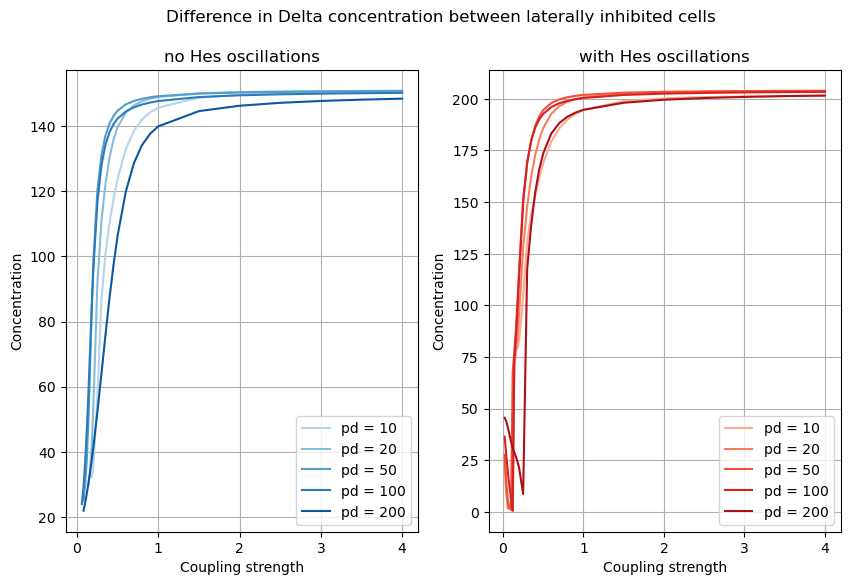

In [254]:
def get_two_colormaps(k, avoid_white=True):
    """
    Returns two lists of k colors each:
    - One from the 'Blues' colormap
    - One from the 'Reds' colormap
    Colors are spaced and trimmed to avoid white and black extremes.
    """
    # Trim range to avoid white (too light) and near-black (too dark)
    min_val, max_val = (0.3, 0.85) if avoid_white else (0.0, 1.0)
    sample_points = np.linspace(min_val, max_val, k)

    blues_cmap = plt.cm.Blues(sample_points)
    reds_cmap = plt.cm.Reds(sample_points)

    # Convert to RGB tuples (remove alpha)
    blues_rgb = [tuple(color[:3]) for color in blues_cmap]
    reds_rgb = [tuple(color[:3]) for color in reds_cmap]

    return blues_rgb, reds_rgb

# Example usage
k = len(p_ds)
blues, reds = get_two_colormaps(k)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_diff_LI_mean_pd_check[1][i],  color = blues[i], label=f'pd = {p_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_diff_LI_mean_pd_hes_check[1][i],  color = reds[i], label=f'pd = {p_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Difference in Delta concentration between laterally inhibited cells')


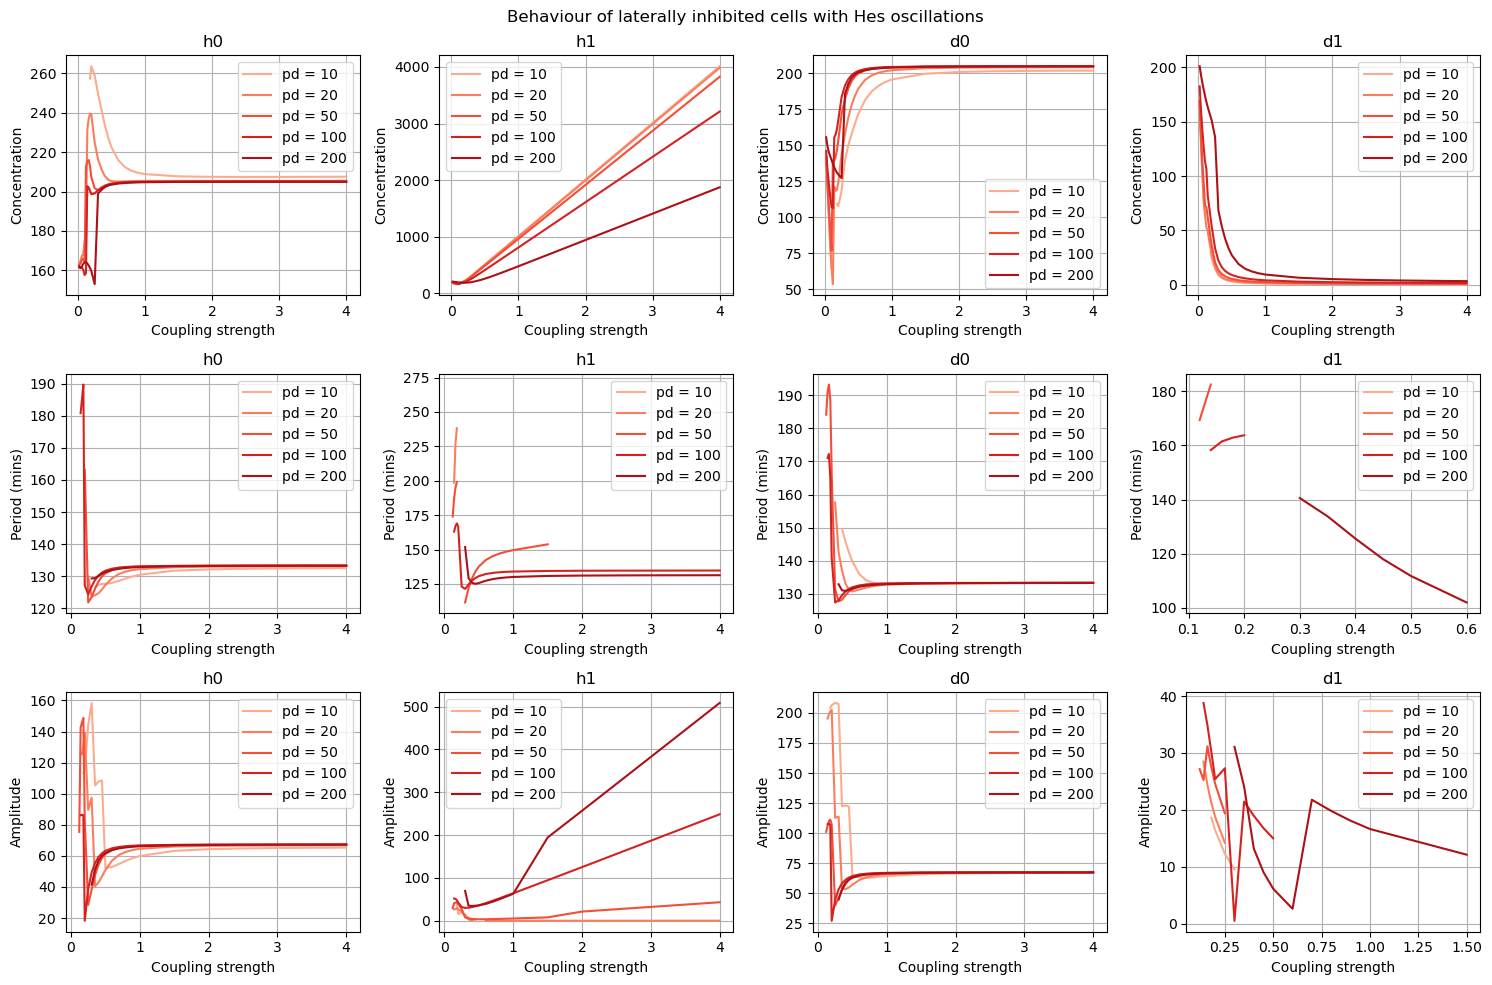

In [255]:
cell = ['h0', 'h1', 'd0', 'd1']
plt.figure(figsize=(15, 10))
plt.subplot(3,4,1)
plt.suptitle('Behaviour of laterally inhibited cells with Hes oscillations')
for c in range(4):
    for i in range(len(p_ds)):
        plt.subplot(3,4,c+1)
        plt.plot(epsilons, result_LI_mean_pd_hes_check[c][i],  color = reds[i], label=f'pd = {p_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Concentration')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4,c+1+4)
        plt.plot(epsilons, result_period_LI_pd_hes_check[c][i],  color = reds[i], label=f'pd = {p_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4, c+1+8)
        plt.plot(epsilons, result_amplitude_LI_pd_hes_check[c][i],  color = reds[i], label=f'pd = {p_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

plt.tight_layout()



#### Vary n

Text(0.5, 0.98, 'Difference in Delta concentration between laterally inhibited cells')

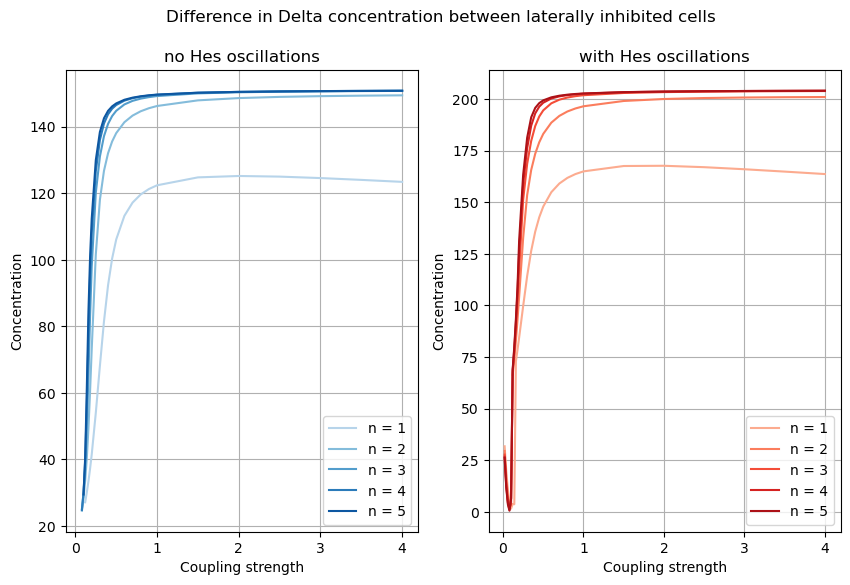

In [256]:
# Example usage
k = len(hill_coeffs)
blues, reds = get_two_colormaps(k)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_diff_LI_mean_n_check[1][i],  color = blues[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_diff_LI_mean_n_hes_check[1][i],  color = reds[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Difference in Delta concentration between laterally inhibited cells')

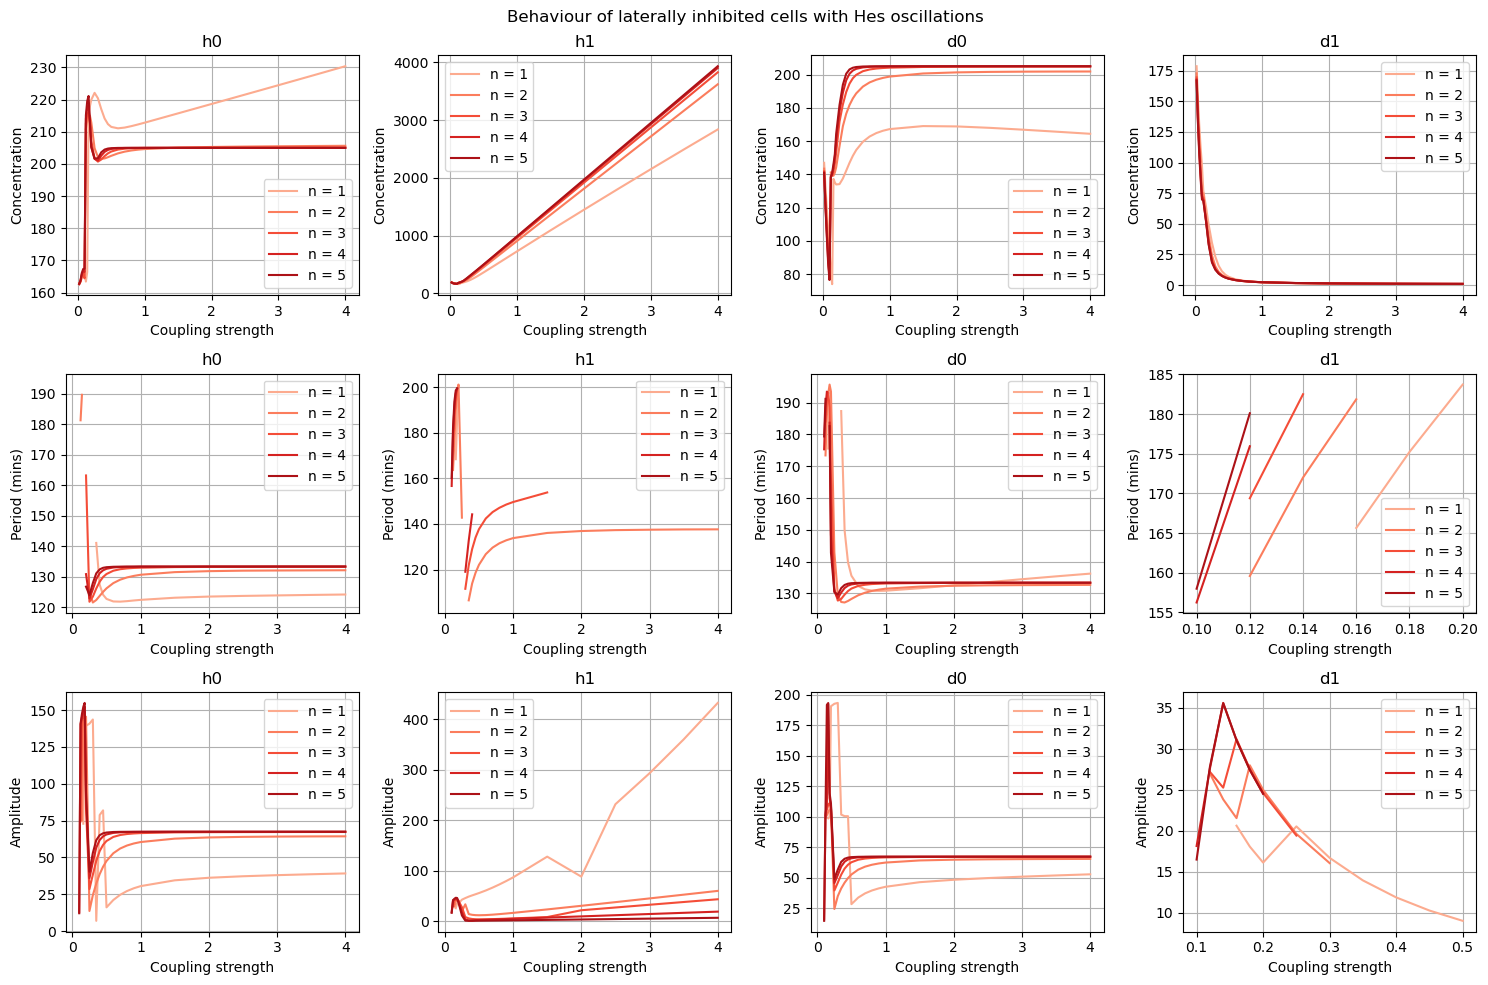

In [257]:
cell = ['h0', 'h1', 'd0', 'd1']
plt.figure(figsize=(15, 10))
plt.subplot(3,4,1)
plt.suptitle('Behaviour of laterally inhibited cells with Hes oscillations')
for c in range(4):
    for i in range(len(hill_coeffs)):
        plt.subplot(3,4,c+1)
        plt.plot(epsilons, result_LI_mean_n_hes_check[c][i],  color = reds[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Concentration')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4,c+1+4)
        plt.plot(epsilons, result_period_LI_n_hes_check[c][i],  color = reds[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4, c+1+8)
        plt.plot(epsilons, result_amplitude_LI_n_hes_check[c][i],  color = reds[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

plt.tight_layout()

#### Vary gamma

Text(0.5, 0.98, 'Difference in Delta concentration between laterally inhibited cells')

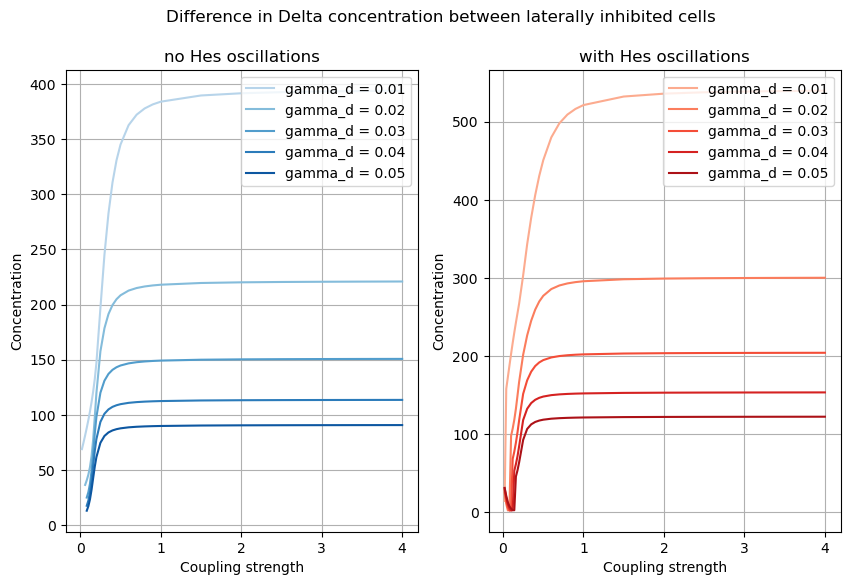

In [258]:
# Example usage
k = len(gamma_ds)
blues, reds = get_two_colormaps(k)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_diff_LI_mean_gamma_check[1][i],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_diff_LI_mean_gamma_hes_check[1][i],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Concentration')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Difference in Delta concentration between laterally inhibited cells')

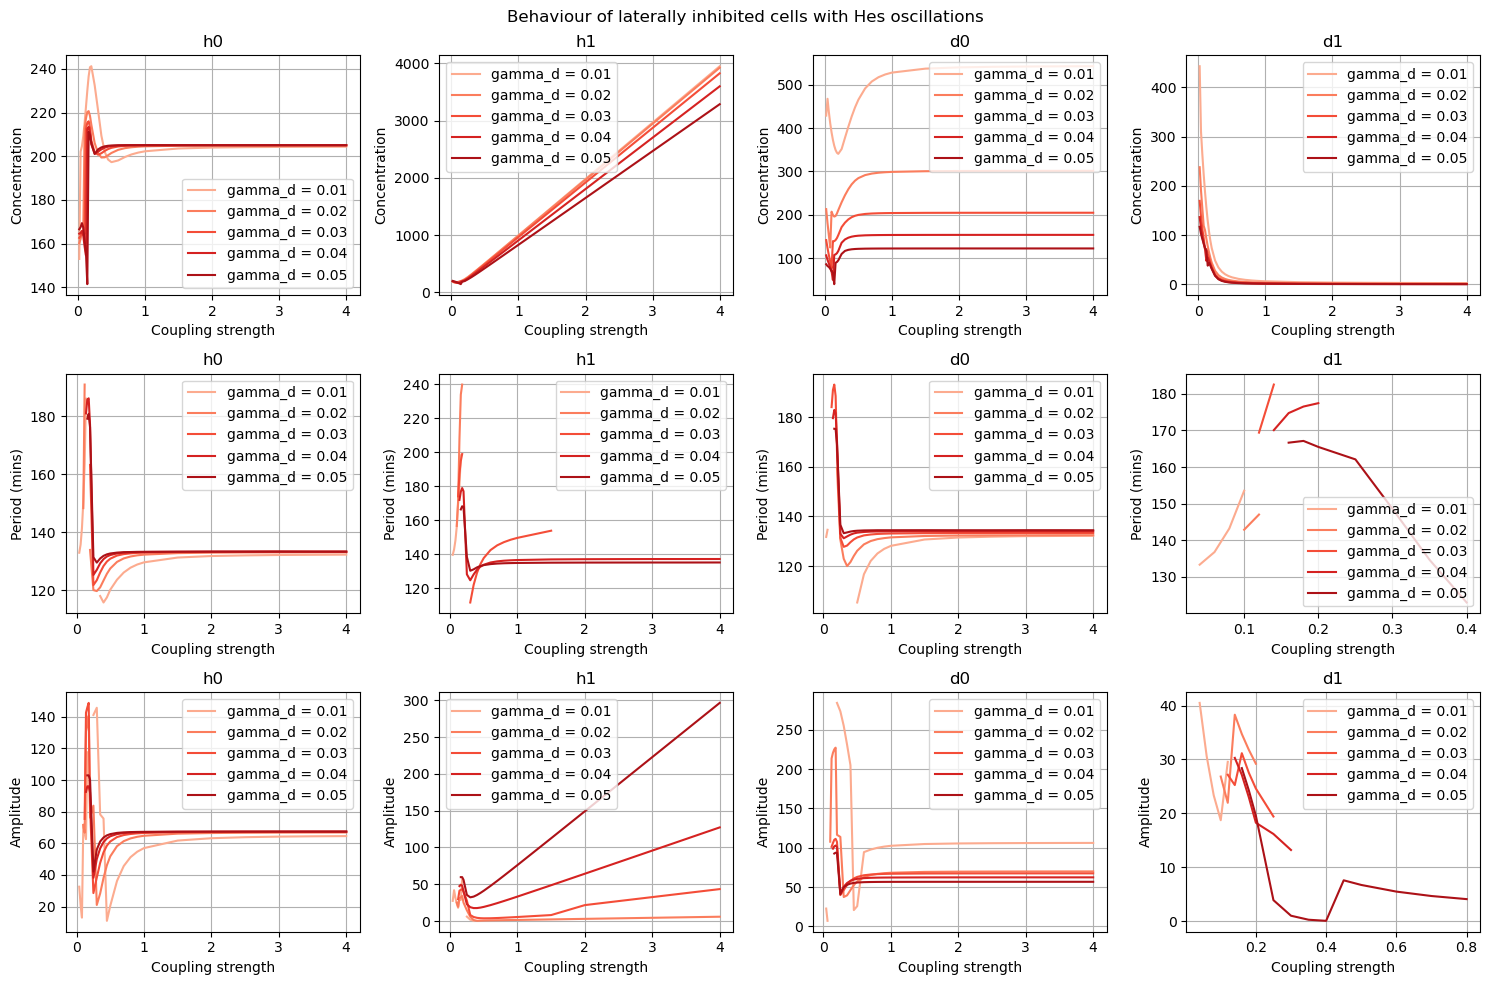

In [259]:
cell = ['h0', 'h1', 'd0', 'd1']
plt.figure(figsize=(15, 10))
plt.subplot(3,4,1)
plt.suptitle('Behaviour of laterally inhibited cells with Hes oscillations')
for c in range(4):
    for i in range(len(gamma_ds)):
        plt.subplot(3,4,c+1)
        plt.plot(epsilons, result_LI_mean_gamma_hes_check[c][i],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Concentration')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4,c+1+4)
        plt.plot(epsilons, result_period_LI_gamma_hes_check[c][i],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(3,4, c+1+8)
        plt.plot(epsilons, result_amplitude_LI_gamma_hes_check[c][i],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

plt.tight_layout()

### Synced states before lateral inhibition

#### Vary pd

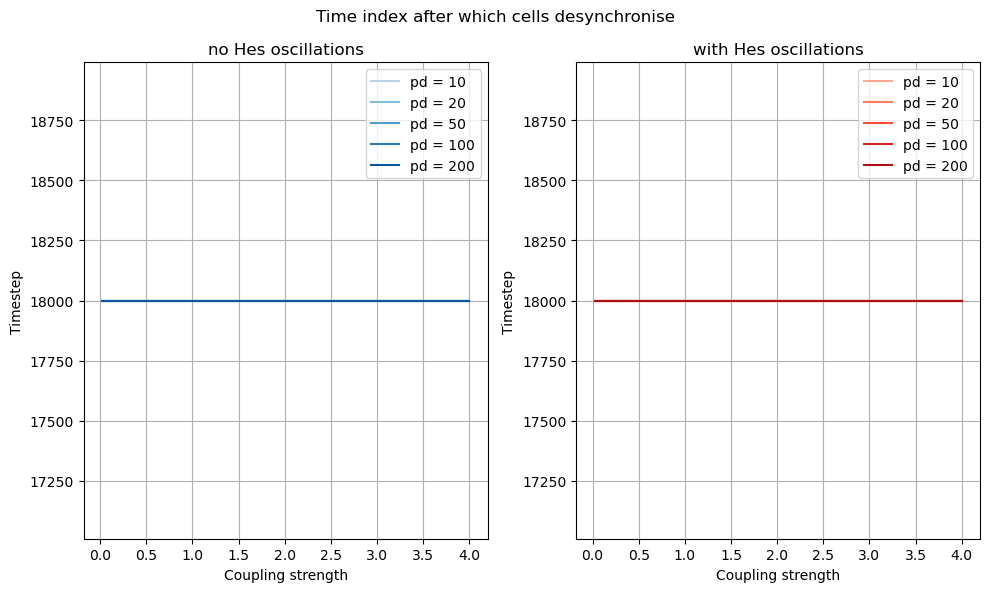

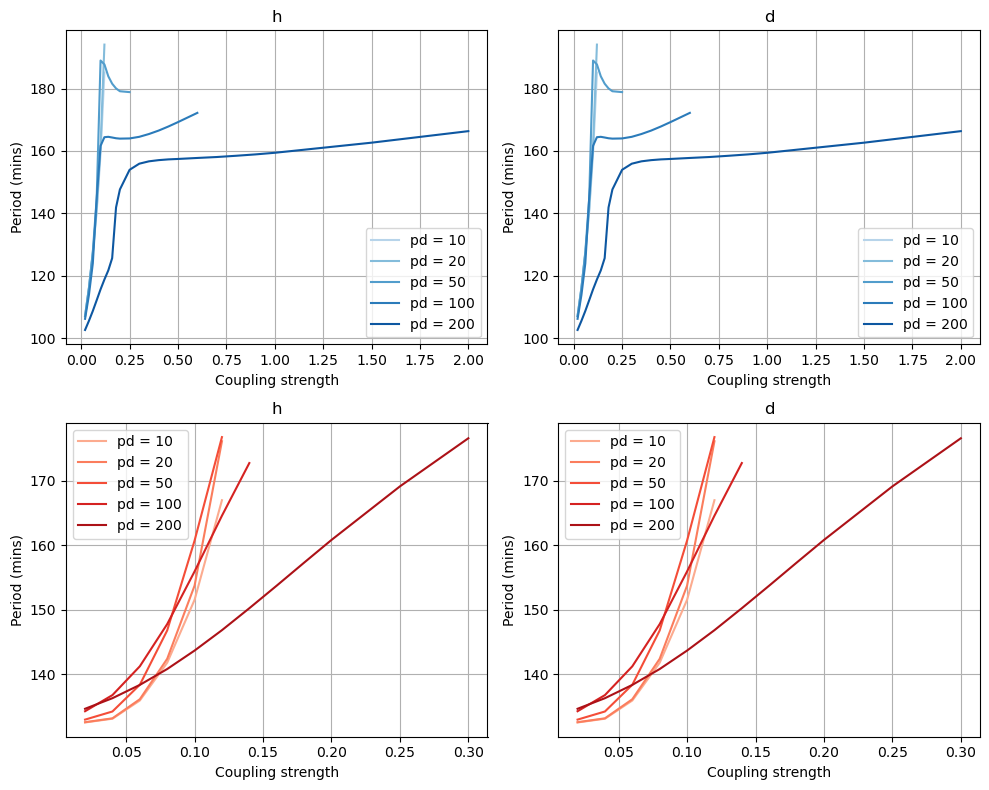

In [260]:
# Example usage
k = len(p_ds)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd[1][i,:],  color = blues[i], label=f'pd = {p_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd_hes[1][i,:],  color = reds[i], label=f'pd = {p_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desynchronise')
plt.tight_layout()

plt.figure(figsize=(10, 8))
for c in range(2):
    for i in range(len(p_ds)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_period_synced_pd[c][i,:],  color = blues[i], label=f'pd = {p_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_period_synced_pd_hes[c][i,:],  color = reds[i], label=f'pd = {p_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()


#### Vary n

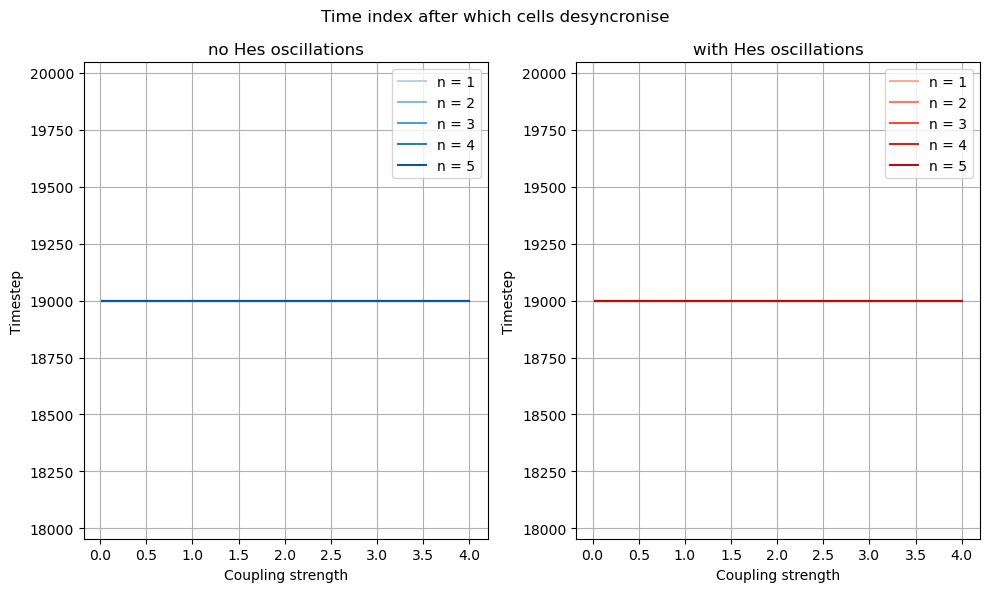

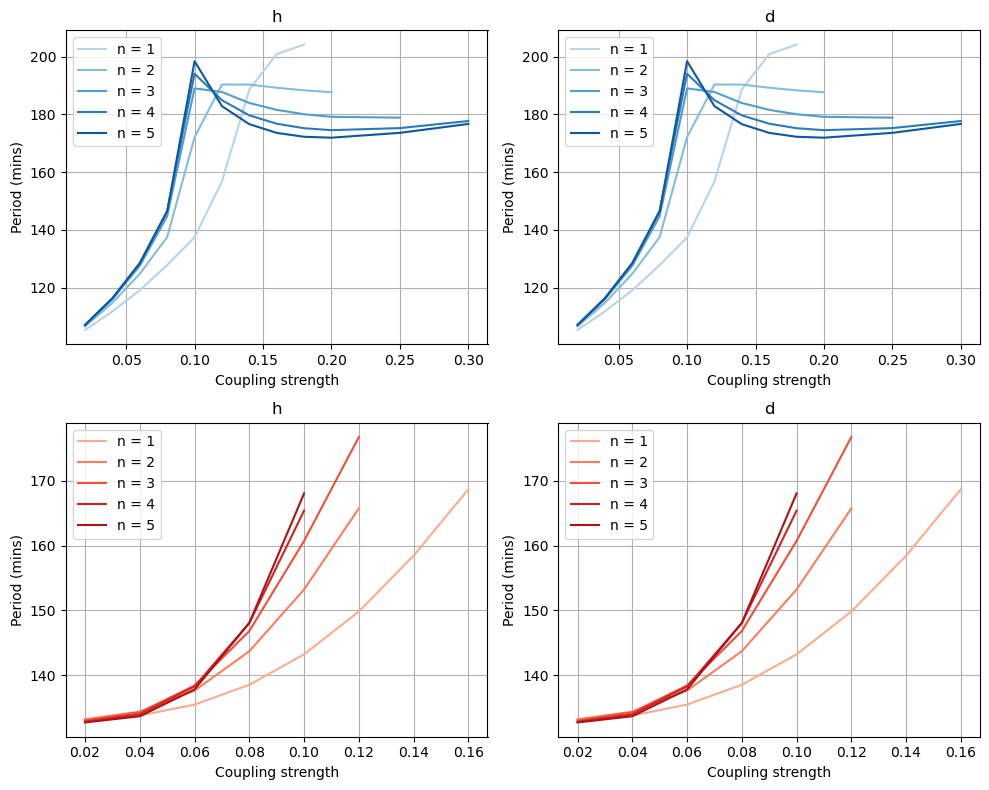

In [247]:

k = len(hill_coeffs)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n[1][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, result_synced_index_n_hes[1][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desyncronise')
plt.tight_layout()

plt.figure(figsize=(10, 8))
for c in range(2):
    for i in range(len(hill_coeffs)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_period_synced_n[c][i,:],  color = blues[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_period_synced_n_hes[c][i,:],  color = reds[i], label=f'n = {hill_coeffs[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

#### Vary gamma

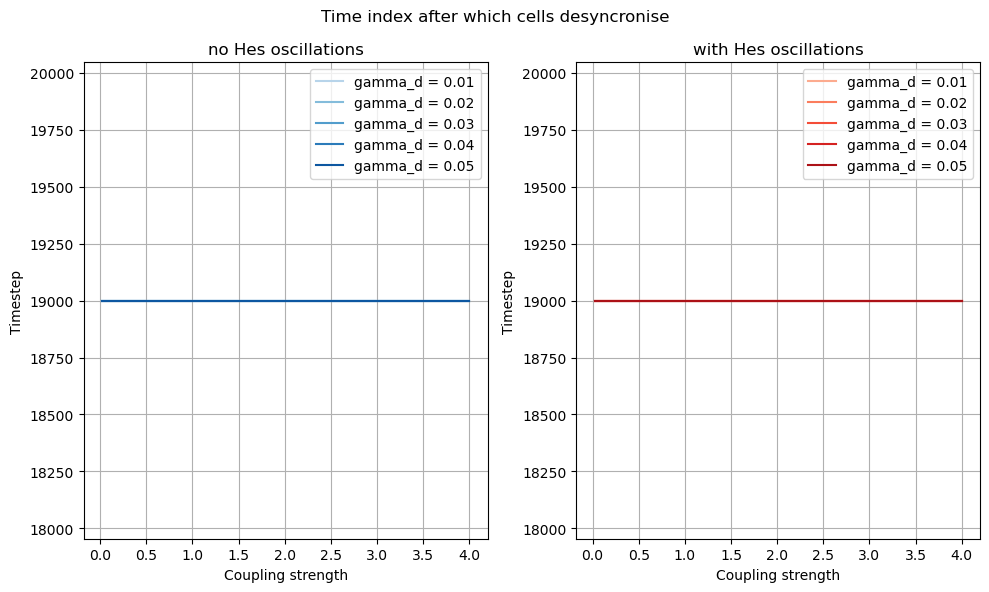

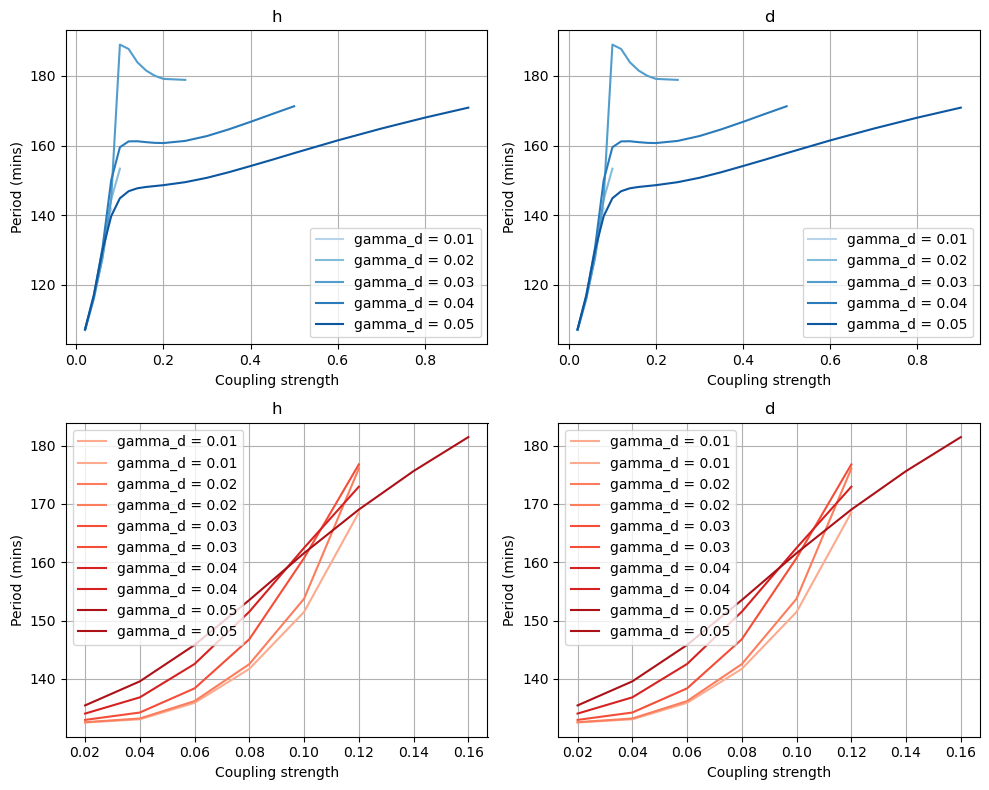

In [248]:

k = len(gamma_ds)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma[1][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma_hes[1][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desyncronise')
plt.tight_layout()

plt.figure(figsize=(10, 8))
for c in range(2):
    for i in range(len(gamma_ds)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_period_synced_gamma[c][i,:],  color = blues[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_period_synced_gamma_hes[c][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.plot(epsilons, result_period_LI_gamma_hes[c][i,:],  color = reds[i], label=f'gamma_d = {gamma_ds[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Period (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

0.16


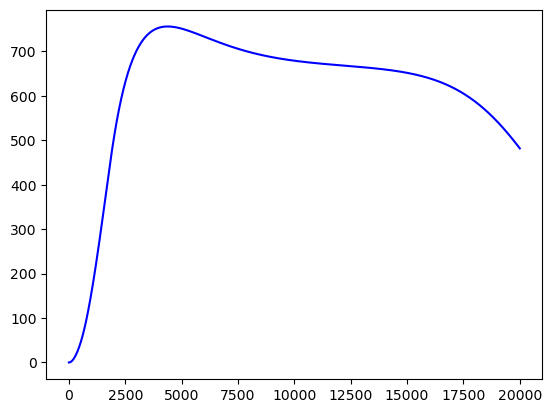

In [218]:
print(epsilons[7])

plt.plot(results_gamma_hes_uni[0, 16, :, 0, 0], color = 'blue') 

In [219]:
5000*0.2

1000.0

### Delay 

Effects on synced part of system

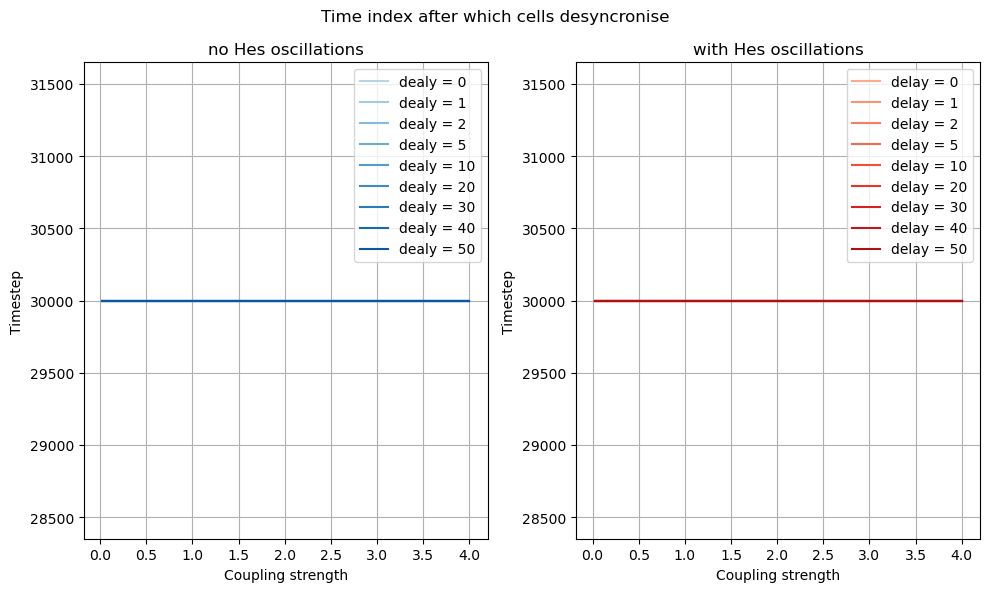

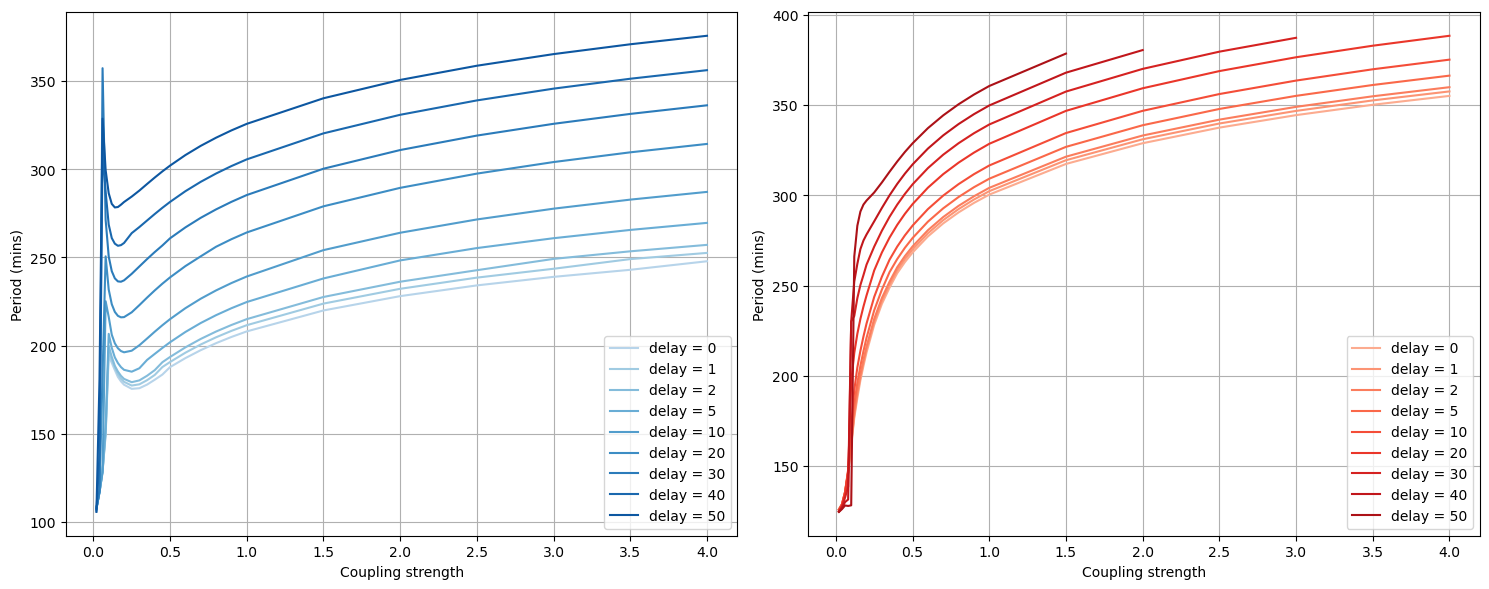

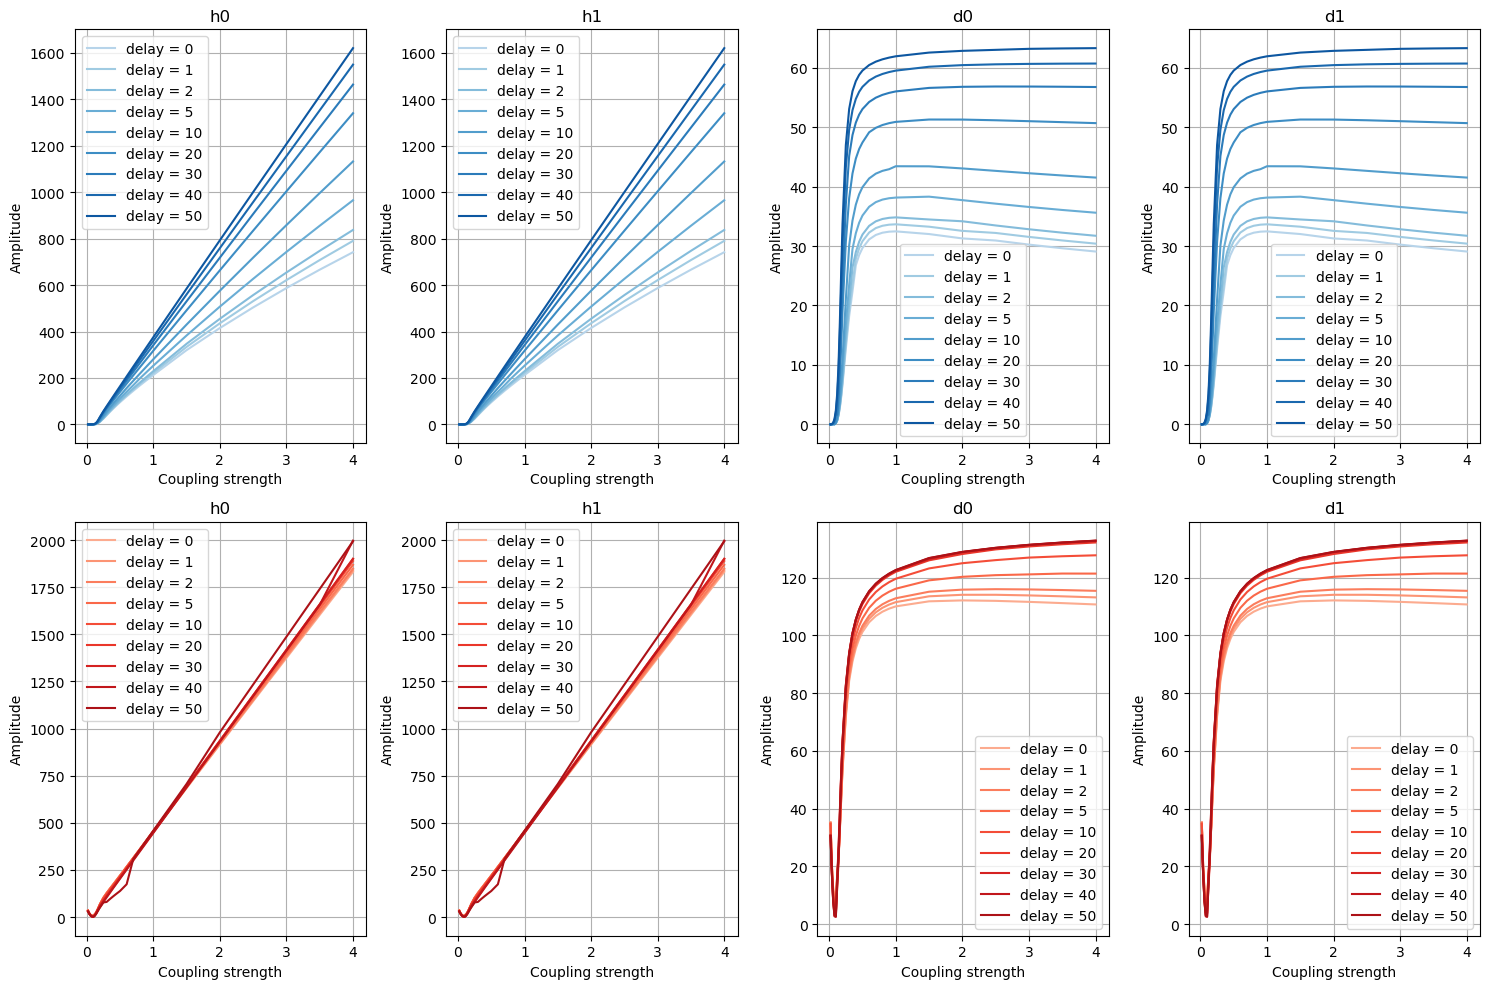

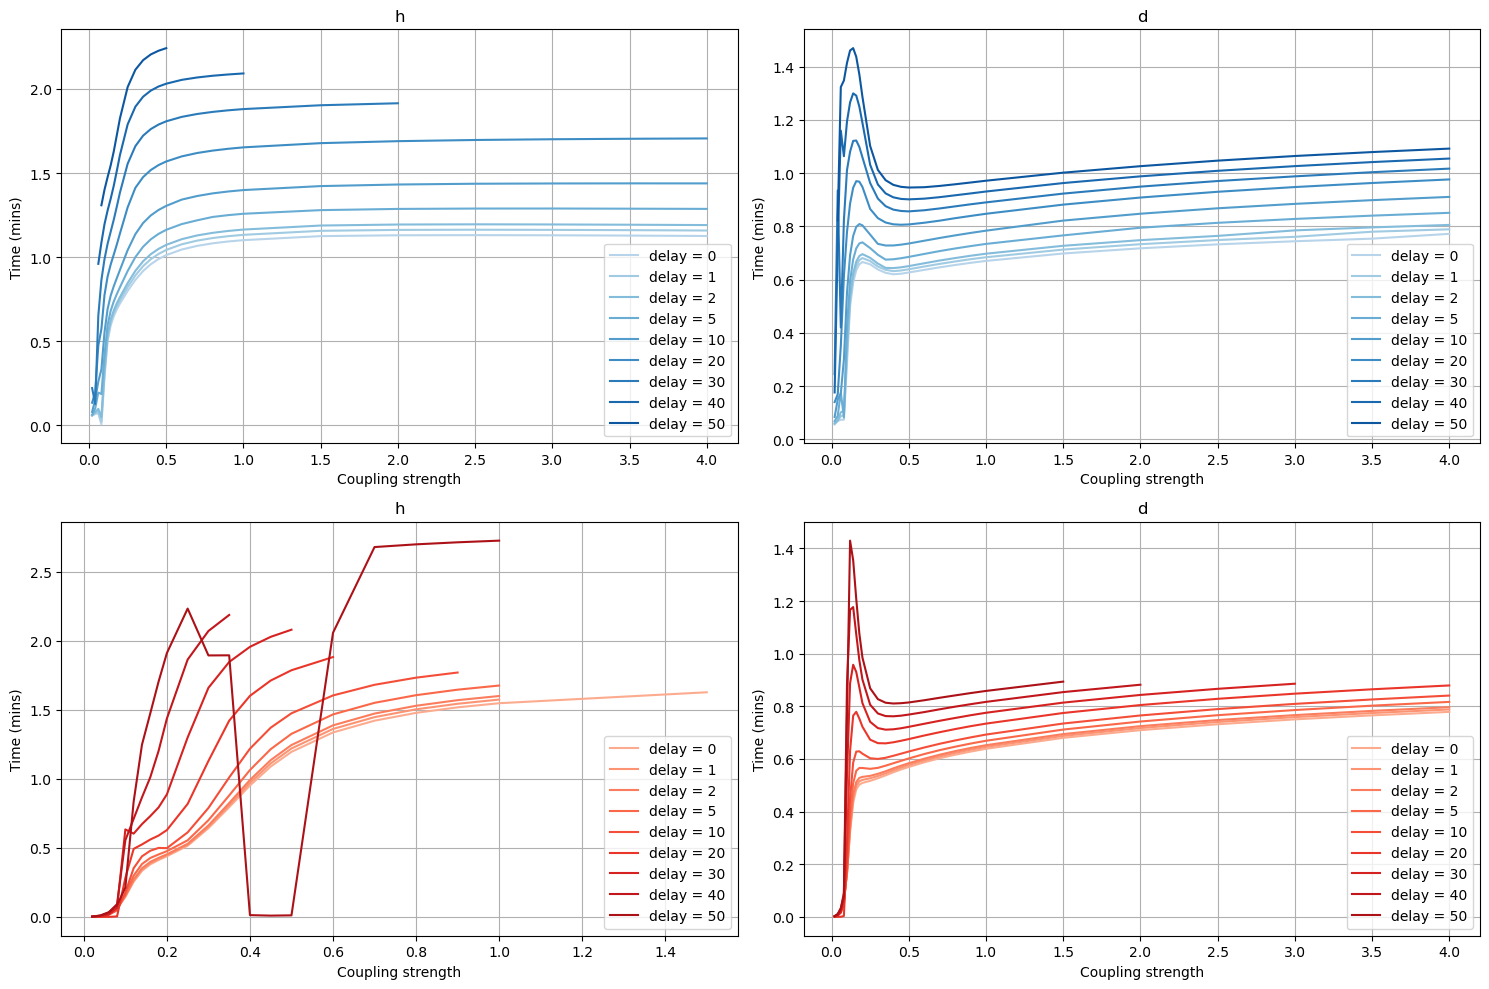

In [268]:
k = len(delays)
blues, reds = get_two_colormaps(k)

cell_type = ['h', 'd']

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay[1][i,:],  color = blues[i], label=f'dealy = {delays[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('no Hes oscillations')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay_hes[1][i,:],  color = reds[i], label=f'delay = {delays[i]}')
plt.xlabel('Coupling strength')
plt.ylabel('Timestep')
plt.title('with Hes oscillations')
plt.legend()
plt.grid()
plt.suptitle('Time index after which cells desyncronise')
plt.tight_layout()

plt.figure(figsize=(15, 6))

for i in range(len(delays)):
    plt.subplot(1,2,1)
    plt.plot(epsilons, result_period_synced_delay[1][i,:],  color = blues[i], label=f'delay = {delays[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    # plt.title(f'{cell_type[c]}')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epsilons, result_period_synced_delay_hes[1][i,:],  color = reds[i], label=f'delay = {delays[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    # plt.title(f'{cell_type[c]}')
    plt.grid()
    plt.legend()

plt.tight_layout()

plt.figure(figsize=(15, 10))

for c in range(4):
    for i in range(len(delays)):
        plt.subplot(2,4,c+1)
        plt.plot(epsilons, result_amplitude_synced_delay[c][i,:],  color = blues[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,4,c+1+4)
        plt.plot(epsilons, result_amplitude_synced_delay_hes[c][i,:],  color = reds[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

plt.figure(figsize=(15, 10))
for c in range(2):
    for i in range(len(delays)):
        plt.subplot(2,2,c+1)
        plt.plot(epsilons, result_shift_delay[c][i,:],  color = blues[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Time (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,2,c+1+2)
        plt.plot(epsilons, result_shift_delay_hes[c][i,:],  color = reds[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Time (mins)')
        plt.title(f'{cell_type[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

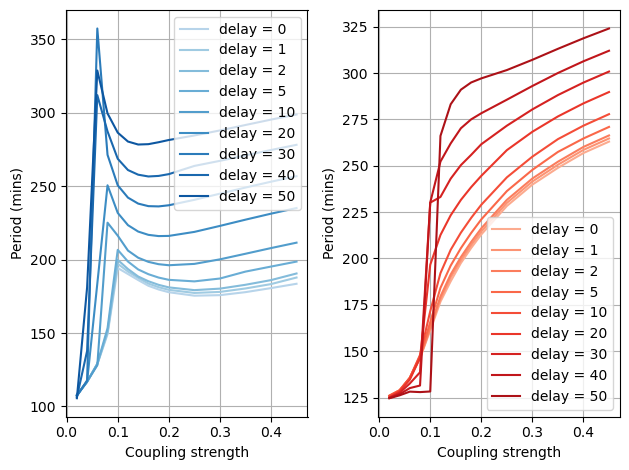

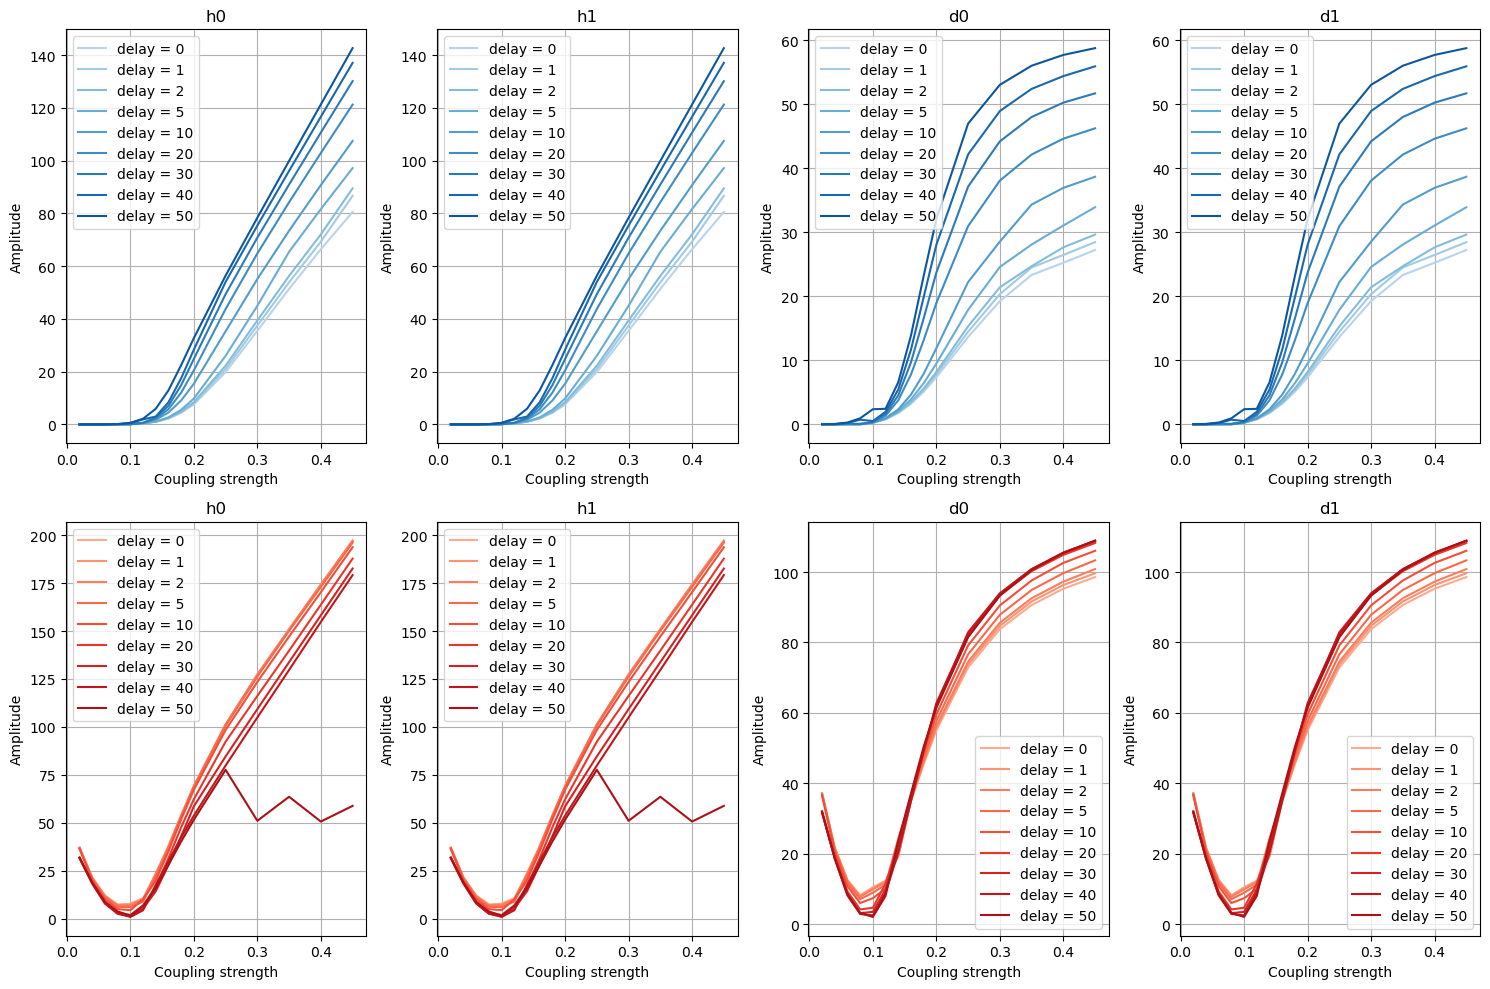

In [264]:
small_epsilons = epsilons[:15]

for i in range(len(delays)):
    plt.subplot(1,2,1)
    plt.plot(small_epsilons, result_period_synced_delay[0][i,:15],  color = blues[i], label=f'delay = {delays[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    # plt.title(f'{cell_type[c]}')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(small_epsilons, result_period_synced_delay_hes[0][i,:15],  color = reds[i], label=f'delay = {delays[i]}')
    plt.xlabel('Coupling strength')
    plt.ylabel('Period (mins)')
    # plt.title(f'{cell_type[c]}')
    plt.grid()
    plt.legend()

plt.tight_layout()

plt.figure(figsize=(15, 10))

for c in range(4):
    for i in range(len(delays)):
        plt.subplot(2,4,c+1)
        plt.plot(small_epsilons, result_amplitude_synced_delay[c][i,:15],  color = blues[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

        plt.subplot(2,4,c+1+4)
        plt.plot(small_epsilons, result_amplitude_synced_delay_hes[c][i,:15],  color = reds[i], label=f'delay = {delays[i]}')
        plt.xlabel('Coupling strength')
        plt.ylabel('Amplitude')
        plt.title(f'{cell[c]}')
        plt.grid()
        plt.legend()

    plt.tight_layout()

In [165]:
300/0.2

1500.0

0 0.25


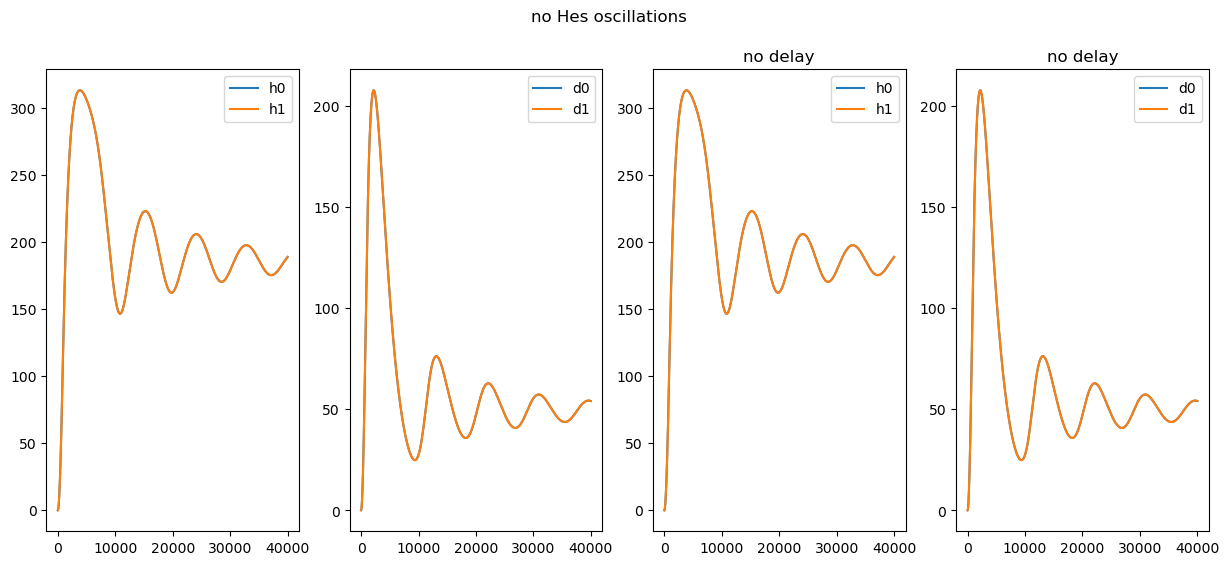

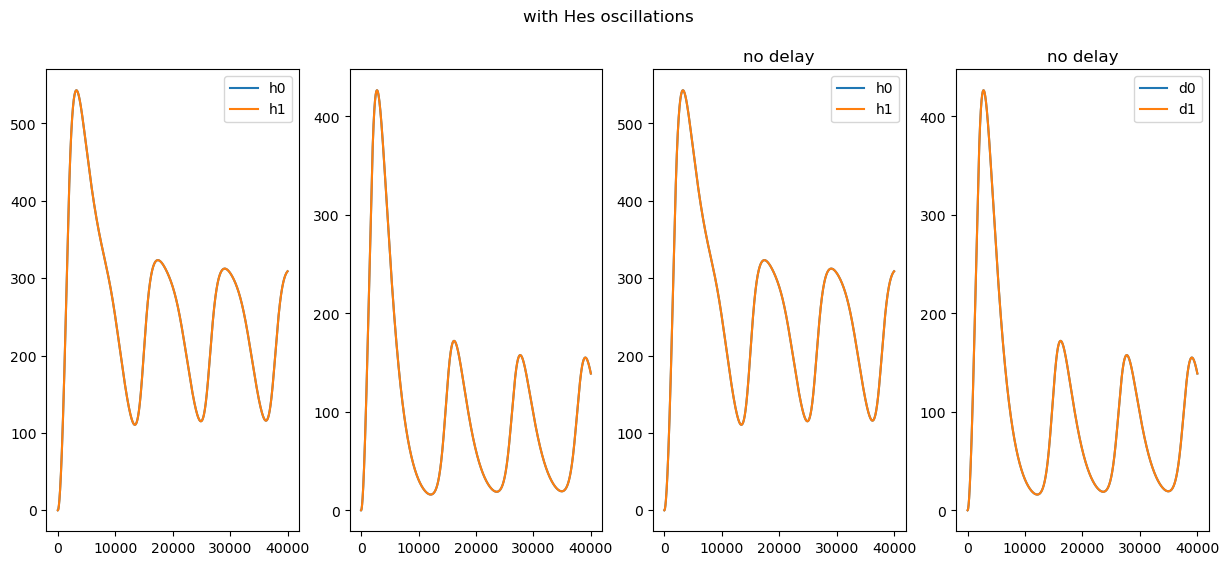

In [178]:
i = 0
j = 10

print(delays[i], epsilons[j])
plt.figure(figsize=(15, 6))
plt.subplot(1,4,1)
plt.plot(results_delay_uniform[i,j,:,0,0], label = 'h0')
plt.plot(results_delay_uniform[i,j,:,0,1], label = 'h1')
plt.legend()
plt.subplot(1,4,2)
plt.plot(results_delay_uniform[i,j,:,1,0], label = 'd0')
plt.plot(results_delay_uniform[i,j,:,1,1], label = 'd1')
plt.suptitle('no Hes oscillations')
plt.legend()

plt.subplot(1,4,3)
plt.title('no delay')
plt.plot(results_delay_uniform[0,j,:,0,0], label = 'h0')
plt.plot(results_delay_uniform[0,j,:,0,1], label = 'h1')
plt.legend()

plt.subplot(1,4,4)
plt.title('no delay')
plt.plot(results_delay_uniform[0,j,:,1,0], label = 'd0')
plt.plot(results_delay_uniform[0,j,:,1,1], label = 'd1')
plt.legend()

plt.figure(figsize=(15, 6))
plt.subplot(1,4,1)
plt.plot(results_delay_hes_uniform[i,j,:,0,0], label = 'h0')
plt.plot(results_delay_hes_uniform[i,j,:,0,1], label = 'h1')
plt.legend()

plt.subplot(1,4,2)
plt.plot(results_delay_hes_uniform[i,j,:,1,0], label = 'd0')
plt.plot(results_delay_hes_uniform[i,j,:,1,1], label = 'd1')
plt.suptitle('with Hes oscillations')

plt.subplot(1,4,3)
plt.title('no delay')
plt.plot(results_delay_hes_uniform[0,j,:,0,0], label = 'h0')
plt.plot(results_delay_hes_uniform[0,j,:,0,1], label = 'h1')
plt.legend()

plt.subplot(1,4,4)
plt.title('no delay')
plt.plot(results_delay_hes_uniform[0,j,:,1,0], label = 'd0')
plt.plot(results_delay_hes_uniform[0,j,:,1,1], label = 'd1')
plt.legend()

In [ ]:
period = estimate_amplitude_from_peaks(results_delay_hes_uniform[0,10,:,0,0])
print(period)

(101.19711847094482, array([17414, 29056], dtype=int64), array([24905, 36238], dtype=int64))


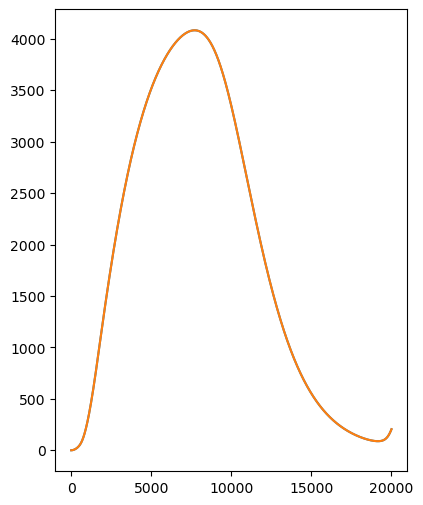

In [126]:
results_pd_hes_uni

p = 2

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(results_pd_hes_uni[p, -1, :, 0, 0], label = 'h0') 
plt.plot(results_pd_hes_uni[p, -1, :, 0, 1], label = 'h1')

# Old plots 

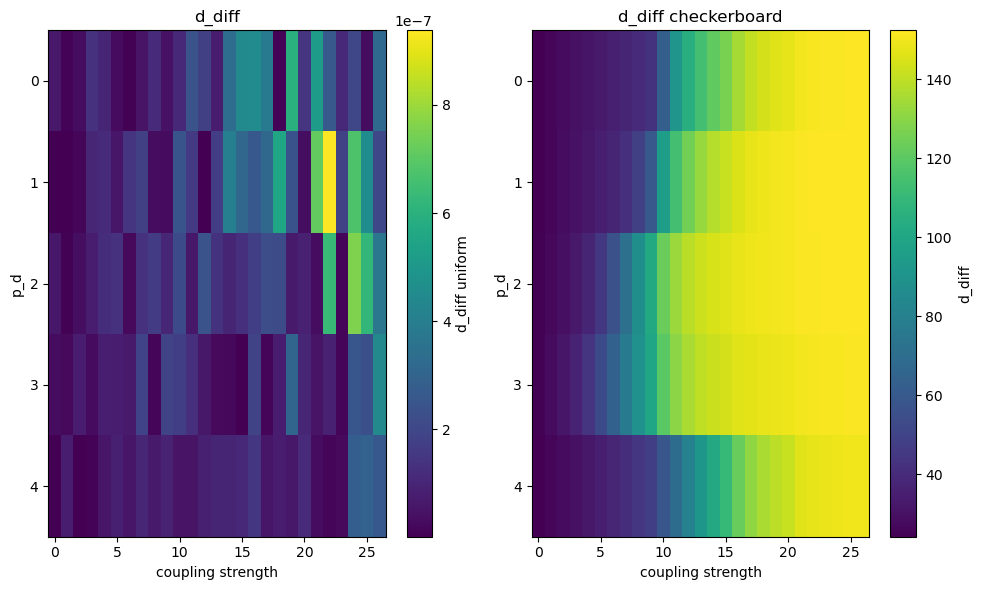

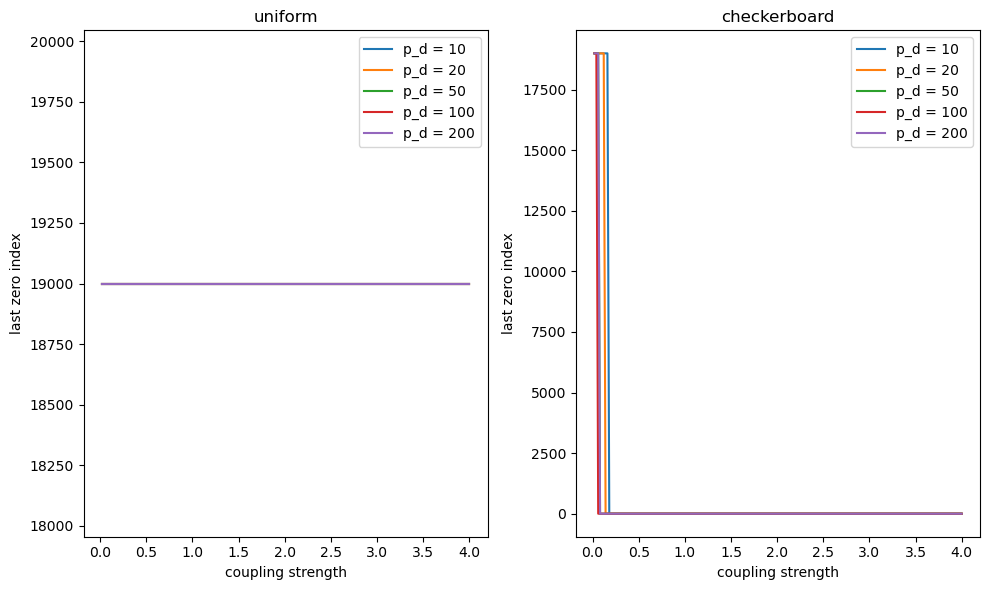

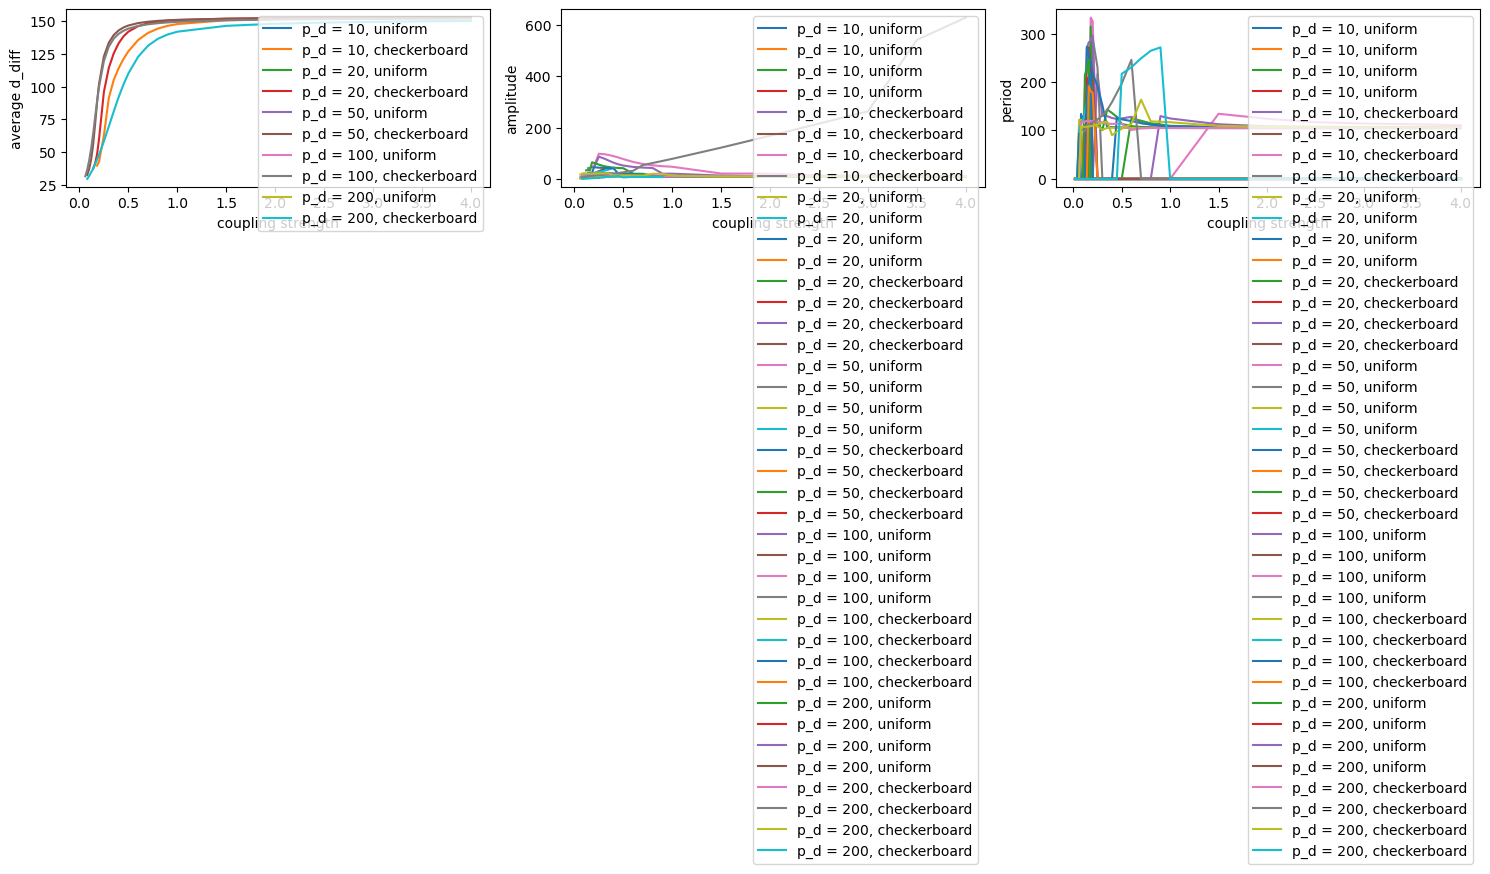

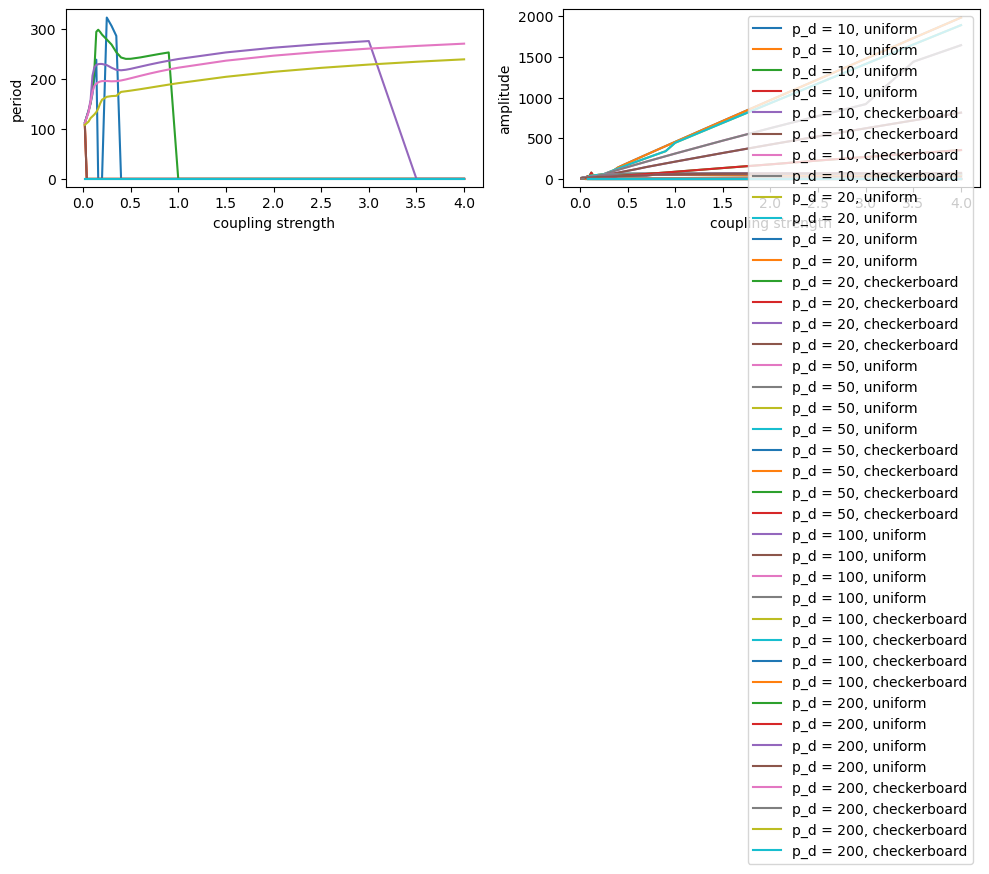

In [26]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(result_diff_pd[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff uniform')
plt.title('d_diff')
plt.xlabel('coupling strength')
plt.ylabel('p_d')

plt.subplot(1, 2, 2)
plt.imshow(np.mean(result_diff_pd_check[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff')
plt.title('d_diff checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('p_d')
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd[-1][i,:], label=f'p_d = {p_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('uniform')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd_check[-1][i,:], label=f'p_d = {p_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('checkerboard')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_diff_LI_mean_pd[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_diff_LI_mean_pd_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('average d_diff')
plt.legend()

plt.subplot(1, 3, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_LI_pd[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd[3][i,:], label=f'p_d = {p_ds[i]}, uniform')

    plt.plot(epsilons, result_amplitude_LI_pd_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')

plt.xlabel('coupling strength')
plt.ylabel('amplitude')
plt.legend()


plt.subplot(1, 3, 3)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_period_LI_pd[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd[3][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')

plt.xlabel('coupling strength')
plt.ylabel('period')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_period_synced_pd[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_synced_pd_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    # plt.plot(epsilons, result_period_synced[1][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[2][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[3][i,:], label=f'p_d = {p_ds[i]}')

plt.xlabel('coupling strength')
plt.ylabel('period')

plt.subplot(1, 2, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_synced_pd[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd[3][i,:], label=f'p_d = {p_ds[i]}, uniform')

    plt.plot(epsilons, result_amplitude_synced_pd_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()




#### Vary pd with Hes osc

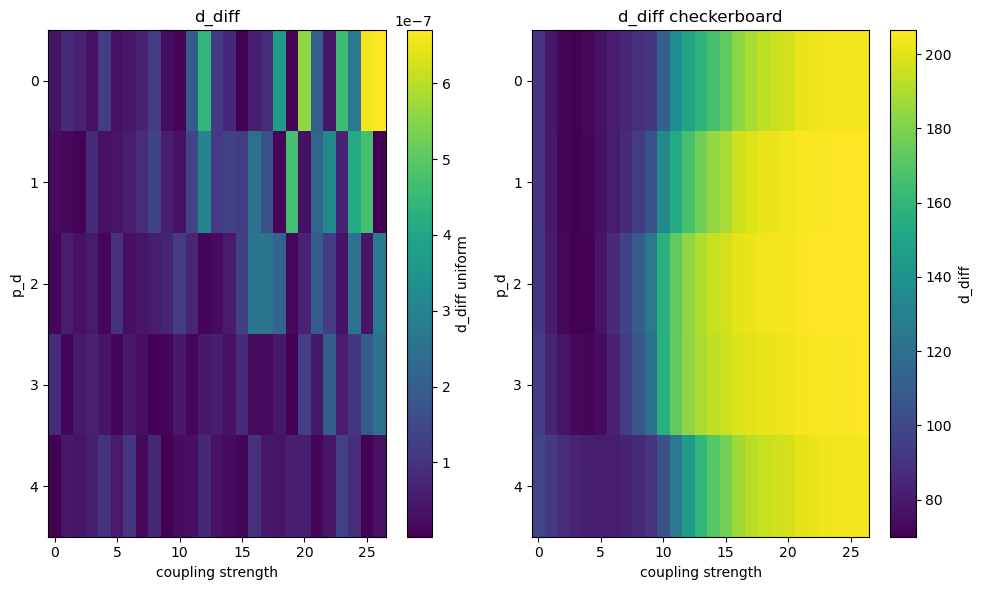

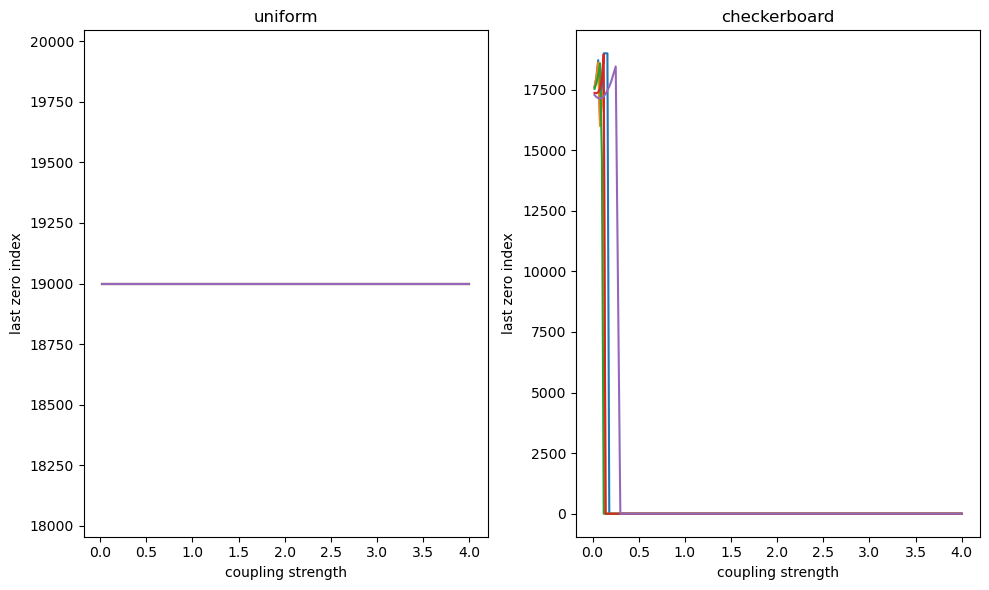

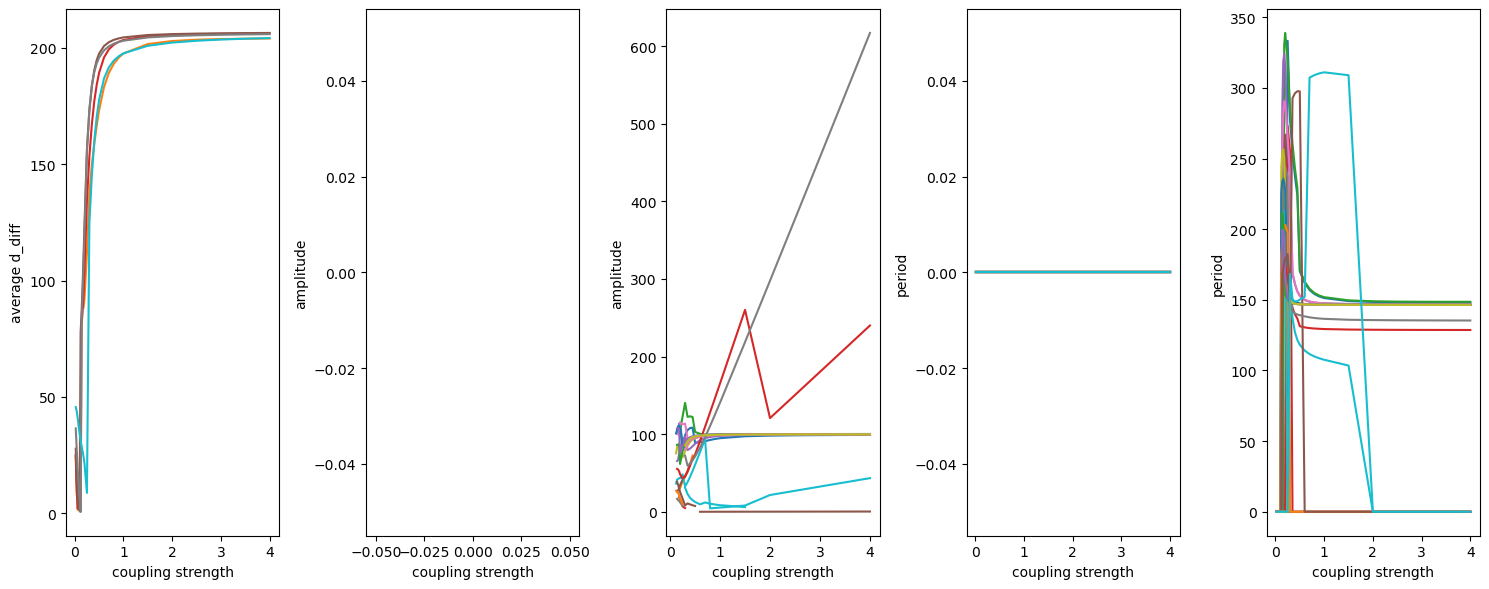

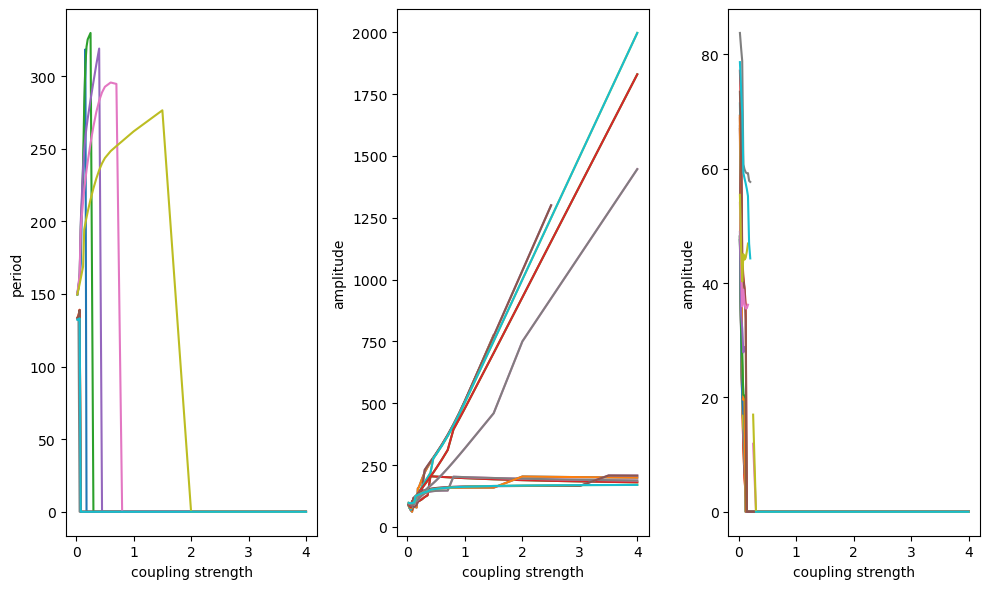

In [27]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(result_diff_pd_hes[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff uniform')
plt.title('d_diff')
plt.xlabel('coupling strength')
plt.ylabel('p_d')

plt.subplot(1, 2, 2)
plt.imshow(np.mean(result_diff_pd_hes_check[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff')
plt.title('d_diff checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('p_d')
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd_hes[-1][i,:], label=f'p_d = {p_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('uniform')
# plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_synced_index_pd_hes_check[-1][i,:], label=f'p_d = {p_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('checkerboard')
# plt.legend()
plt.tight_layout()

plt.figure(figsize=(15, 6))
plt.subplot(1, 5, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_diff_LI_mean_pd_hes[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_diff_LI_mean_pd_hes_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('average d_diff')
# plt.legend()

plt.subplot(1, 5, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_LI_pd_hes[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd_hes[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd_hes[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_LI_pd_hes[3][i,:], label=f'p_d = {p_ds[i]}, uniform')

plt.xlabel('coupling strength')
plt.ylabel('amplitude')
# plt.legend()

plt.subplot(1, 5, 3)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_LI_pd_hes_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_hes_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_hes_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_LI_pd_hes_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')

plt.xlabel('coupling strength')
plt.ylabel('amplitude')
# plt.legend()


plt.subplot(1, 5, 4)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_period_LI_pd_hes[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd_hes[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd_hes[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_LI_pd_hes[3][i,:], label=f'p_d = {p_ds[i]}, uniform')

plt.xlabel('coupling strength')
plt.ylabel('period')
# plt.legend()
plt.tight_layout()

plt.subplot(1, 5, 5)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_period_LI_pd_hes_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_hes_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_hes_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_period_LI_pd_hes_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
plt.xlabel('coupling strength')
plt.ylabel('period')
# plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_period_synced_pd_hes[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_period_synced_pd_hes_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    # plt.plot(epsilons, result_period_synced[1][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[2][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[3][i,:], label=f'p_d = {p_ds[i]}')

plt.xlabel('coupling strength')
plt.ylabel('period')

plt.subplot(1, 3, 2)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_synced_pd_hes[0][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd_hes[1][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd_hes[2][i,:], label=f'p_d = {p_ds[i]}, uniform')
    plt.plot(epsilons, result_amplitude_synced_pd_hes[3][i,:], label=f'p_d = {p_ds[i]}, uniform')
plt.xlabel('coupling strength')
plt.ylabel('amplitude')
# plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 3)
for i in range(len(p_ds)):
    plt.plot(epsilons, result_amplitude_synced_pd_hes_check[0][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_hes_check[1][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_hes_check[2][i,:], label=f'p_d = {p_ds[i]}, checkerboard')
    plt.plot(epsilons, result_amplitude_synced_pd_hes_check[3][i,:], label=f'p_d = {p_ds[i]}, checkerboard')

plt.xlabel('coupling strength')
plt.ylabel('amplitude')
# plt.legend()
plt.tight_layout()
plt.show()

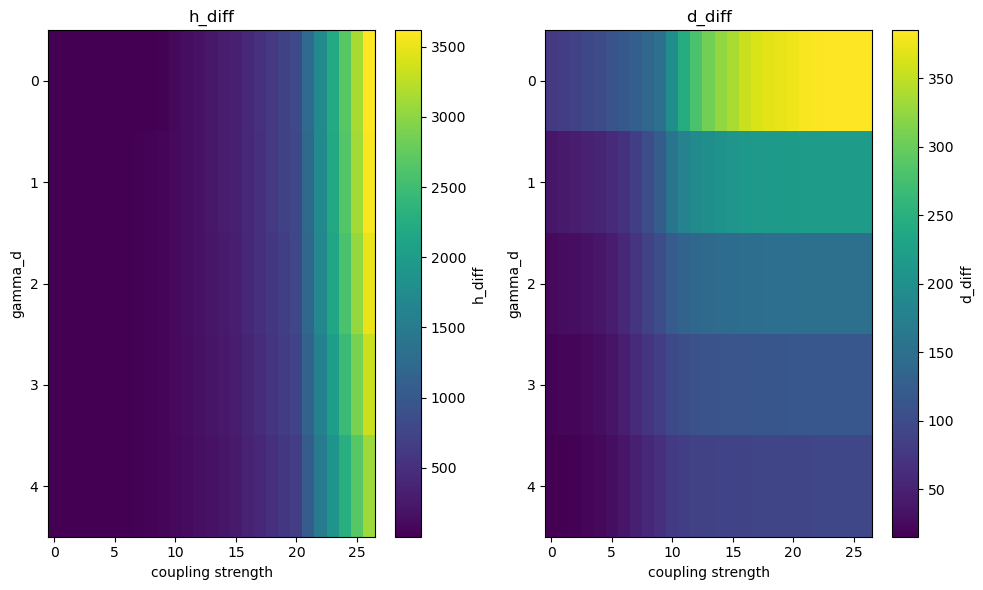

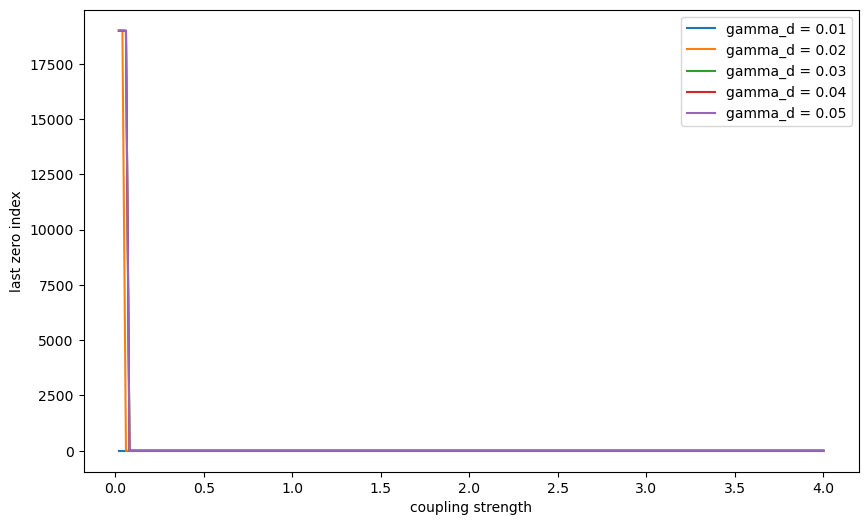

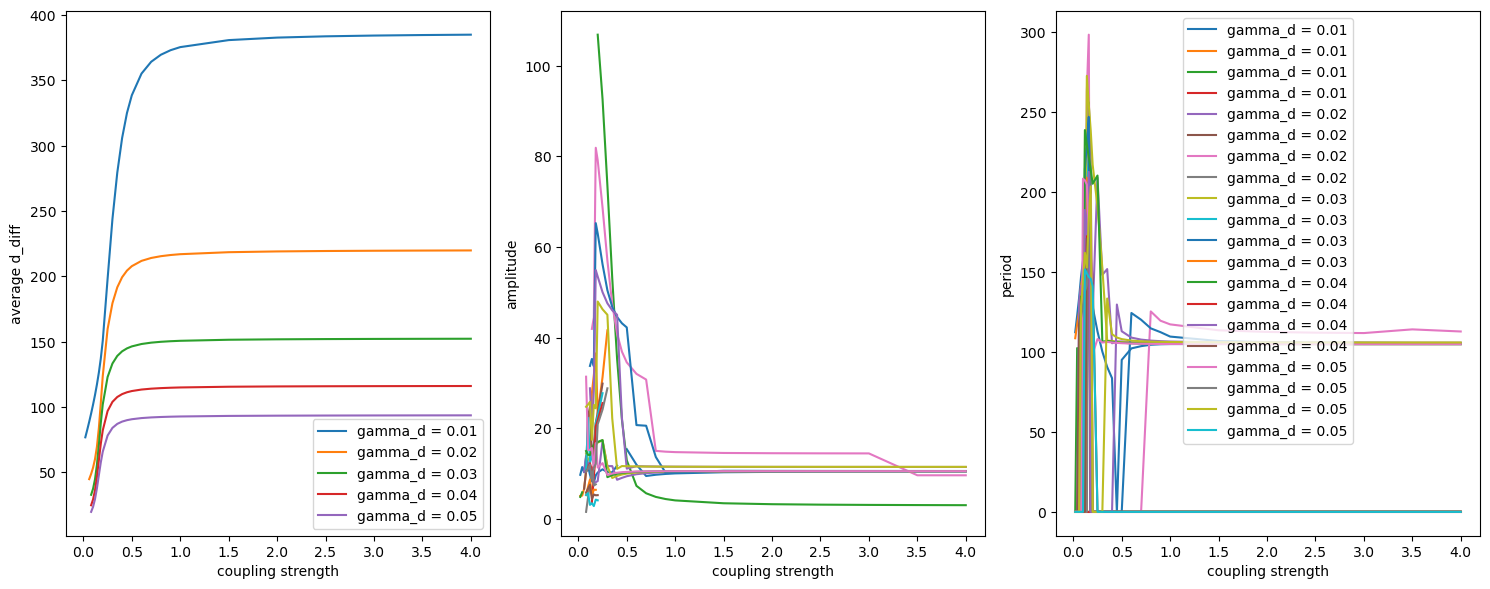

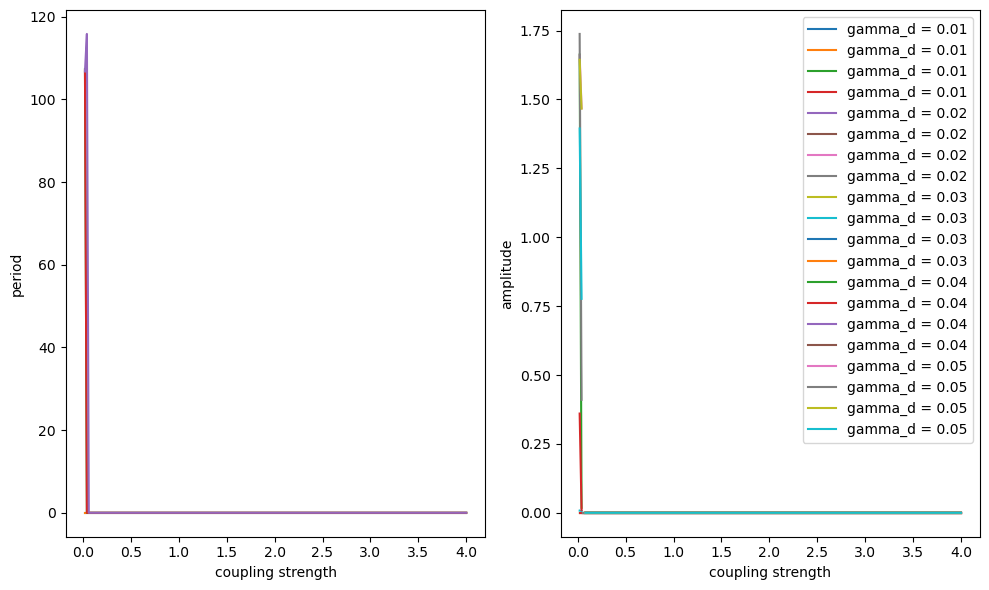

In [13]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(result_diff_gamma[0], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='h_diff')
plt.title('h_diff')
plt.xlabel('coupling strength')
plt.ylabel('gamma_d')

plt.subplot(1, 2, 2)
plt.imshow(np.mean(result_diff_gamma[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff')
plt.title('d_diff')
plt.xlabel('coupling strength')
plt.ylabel('gamma_d')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_synced_index_gamma[-1][i,:], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.legend()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_diff_LI_mean_gamma[1][i,:], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('average d_diff')
plt.legend()

plt.subplot(1, 3, 2)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_amplitude_LI_gamma[0][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_LI_gamma[1][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_LI_gamma[2][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_LI_gamma[3][i,:], label=f'gamma_d = {gamma_ds[i]}')

plt.xlabel('coupling strength')
plt.ylabel('amplitude')

plt.subplot(1, 3, 3)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_period_LI_gamma[0][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_period_LI_gamma[1][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_period_LI_gamma[2][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_period_LI_gamma[3][i,:], label=f'gamma_d = {gamma_ds[i]}')

plt.xlabel('coupling strength')
plt.ylabel('period')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2,1)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_period_synced_gamma[0][i,:], label=f'gamma_d = {gamma_ds[i]}')
    # plt.plot(epsilons, result_period_synced[1][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[2][i,:], label=f'p_d = {p_ds[i]}')
    # plt.plot(epsilons, result_period_synced[3][i,:], label=f'p_d = {p_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('period')

plt.subplot(1, 2, 2)
for i in range(len(gamma_ds)):
    plt.plot(epsilons, result_amplitude_synced_gamma[0][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_synced_gamma[1][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_synced_gamma[2][i,:], label=f'gamma_d = {gamma_ds[i]}')
    plt.plot(epsilons, result_amplitude_synced_gamma[3][i,:], label=f'gamma_d = {gamma_ds[i]}')
plt.xlabel('coupling strength')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()



#### Plot Hes oscillations with delays

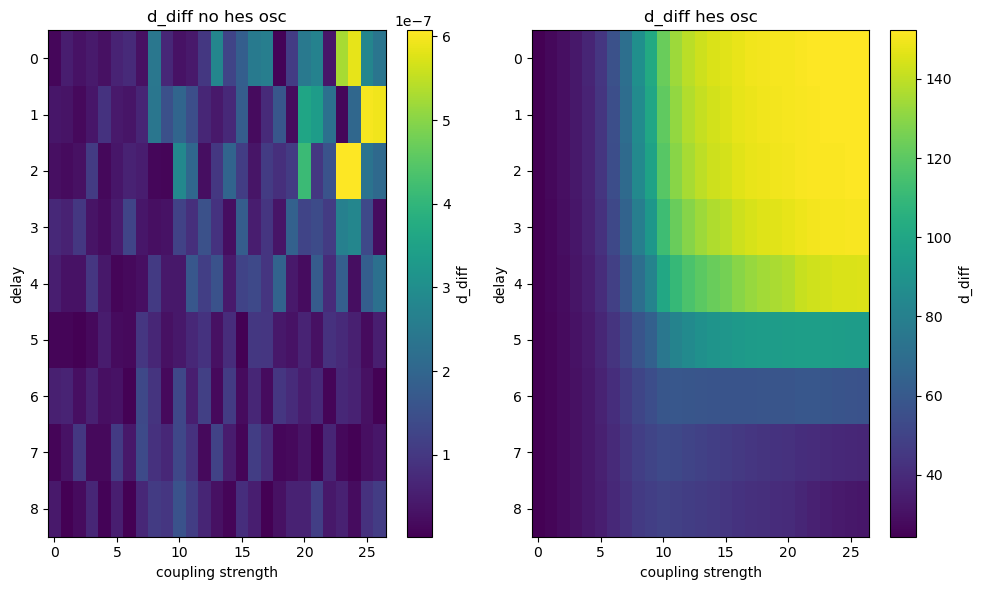

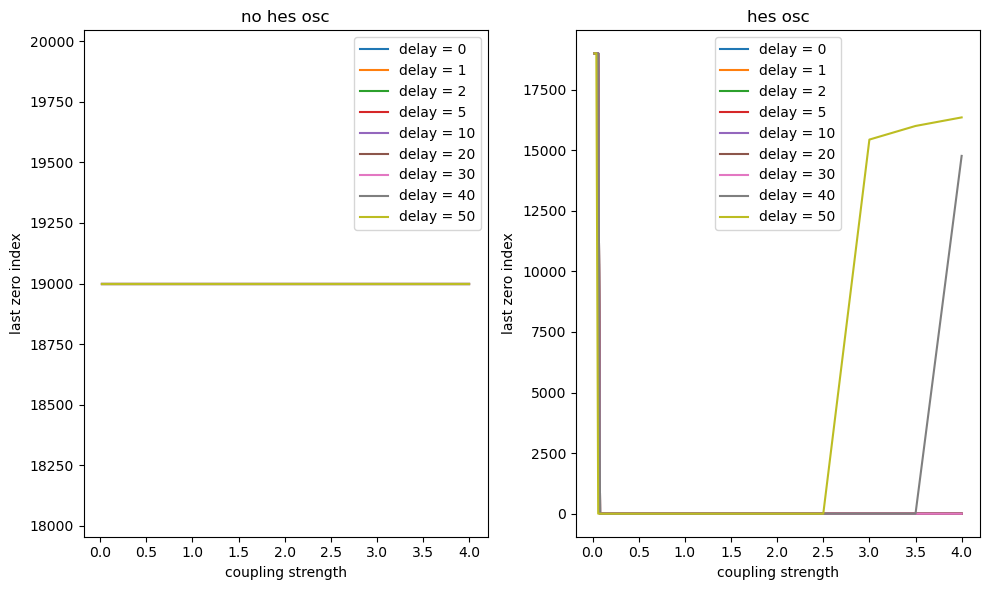

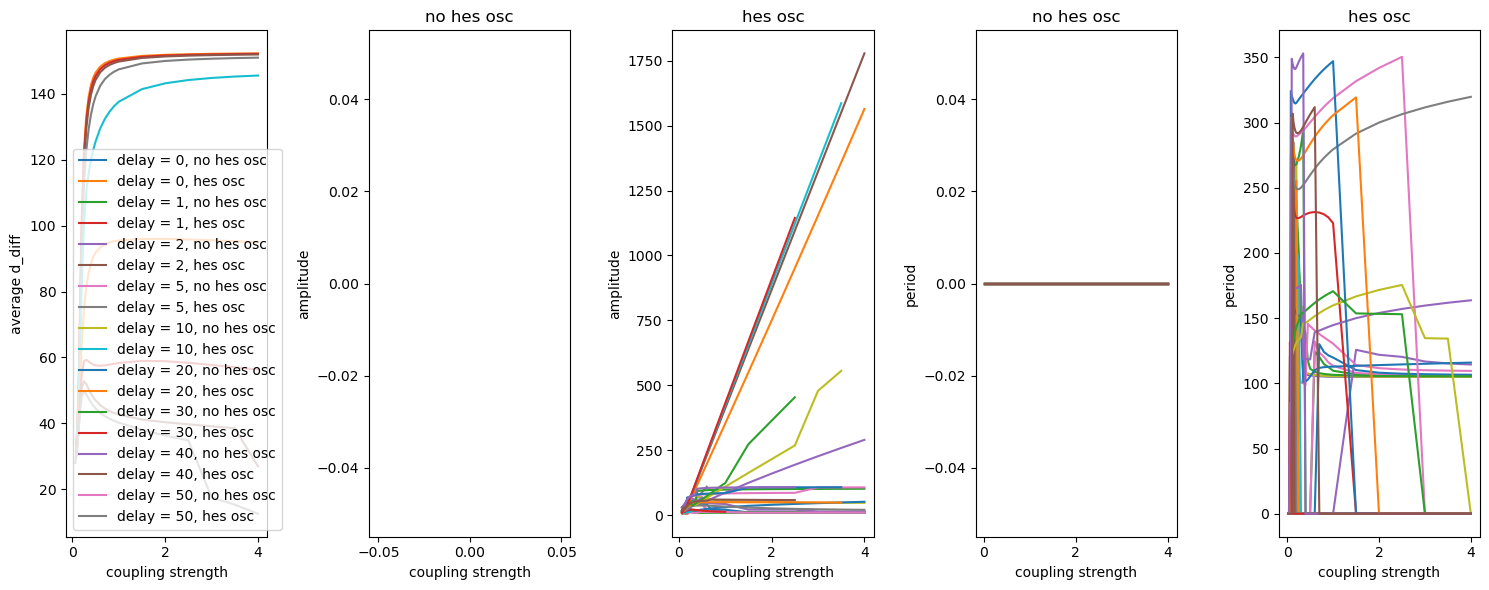

In [38]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(result_diff_delay[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff')
plt.title('d_diff no hes osc')
plt.xlabel('coupling strength')
plt.ylabel('delay')

plt.subplot(1, 2, 2)
plt.imshow(np.mean(result_diff_delay_hes[1], axis=2), aspect='auto', cmap='viridis')
plt.colorbar(label='d_diff')
plt.title('d_diff hes osc')
plt.xlabel('coupling strength')
plt.ylabel('delay')
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay[-1][i,:], label=f'delay = {delays[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('no hes osc')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(delays)):
    plt.plot(epsilons, result_synced_index_delay_hes[-1][i,:], label=f'delay = {delays[i]}')
plt.xlabel('coupling strength')
plt.ylabel('last zero index')
plt.title('hes osc')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(15, 6))
plt.subplot(1, 5, 1)
for i in range(len(delays)):
    plt.plot(epsilons, result_diff_LI_mean_delay[1][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_diff_LI_mean_delay_hes[1][i,:], label=f'delay = {delays[i]}, hes osc')
plt.xlabel('coupling strength')
plt.ylabel('average d_diff')
plt.legend()

plt.subplot(1, 5, 2)
for i in range(len(delays)):
    plt.plot(epsilons, result_amplitude_LI_delay[0][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay[1][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay[2][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay[3][i,:], label=f'delay = {delays[i]}, no hes osc')
plt.xlabel('coupling strength')
plt.ylabel('amplitude')
plt.title('no hes osc')

plt.subplot(1, 5, 3)
for i in range(len(delays)):
    plt.plot(epsilons, result_amplitude_LI_delay_hes[0][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay_hes[1][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay_hes[2][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_amplitude_LI_delay_hes[3][i,:], label=f'delay = {delays[i]}, hes osc')
plt.xlabel('coupling strength')
plt.ylabel('amplitude')
plt.title('hes osc')

plt.subplot(1, 5, 4)
for i in range(len(delays)):
    plt.plot(epsilons, result_period_LI_delay[0][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_period_LI_delay[1][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_period_LI_delay[2][i,:], label=f'delay = {delays[i]}, no hes osc')
    plt.plot(epsilons, result_period_LI_delay[3][i,:], label=f'delay = {delays[i]}, no hes osc')
plt.xlabel('coupling strength')
plt.ylabel('period')
plt.title('no hes osc')

plt.subplot(1, 5, 5)
for i in range(len(delays)):
    plt.plot(epsilons, result_period_LI_delay_hes[0][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_period_LI_delay_hes[1][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_period_LI_delay_hes[2][i,:], label=f'delay = {delays[i]}, hes osc')
    plt.plot(epsilons, result_period_LI_delay_hes[3][i,:], label=f'delay = {delays[i]}, hes osc')
plt.xlabel('coupling strength')
plt.ylabel('period')
plt.title('hes osc')
plt.tight_layout()
plt.show()


#### Influence on delay

### With Hes oscillations and checkerboard initialisation

Results: Checkerboard initialisation is to force it into it's final lateral inhibited state quickly. Here we see that with Hes oscillations. The oscillations remain even in the laterally inhibited state. The amplitude of the oscillations differ for different coupling strenghts. Again the Delta dynamics seem restrained whereas the Hes dynamics grow for higher coupling strength. 

### With Hes and uniform initialisation

Want to see when the system goes into lateral inhibition and see the properties of the system before it laterally inhibits. 

The system doesn't work nicely for very low p_d (p_d = 10) and for n = 1.

### Vary delay in coupling for Hes oscillating 2 cells

In [71]:
# Get 20 colors from the viridis colormap
viridis = plt.cm.get_cmap('viridis', 20)
colors = [viridis(i) for i in range(20)]


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_20452\1209775591.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 20)


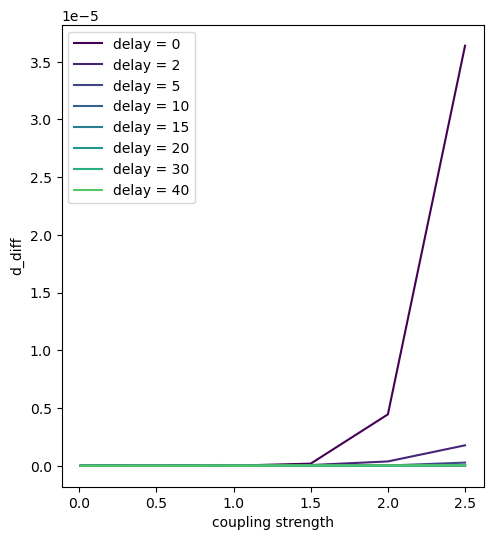

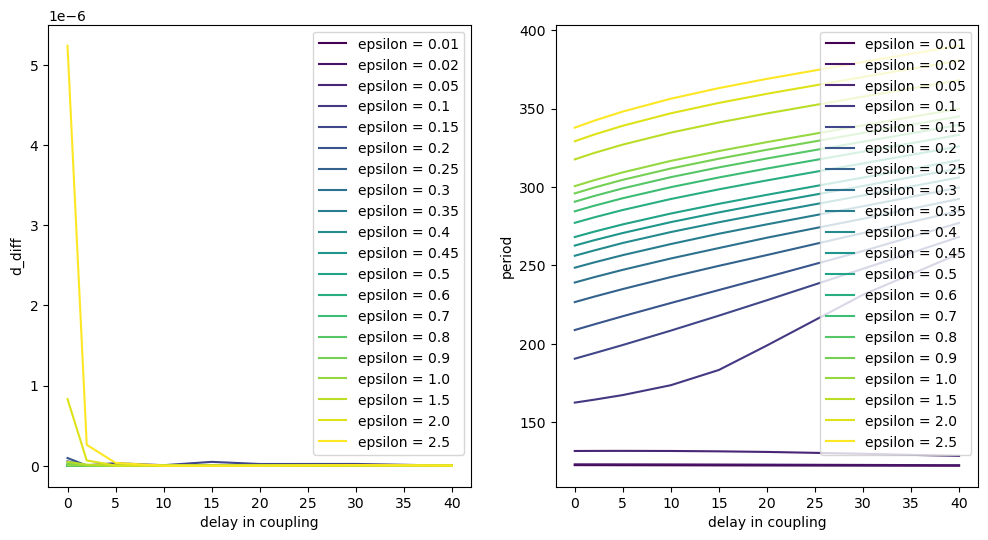

In [74]:
h_diff = np.zeros((len(delay_coupling), len(epsilons), num_tsteps - time_start))
d_diff = np.zeros((len(delay_coupling), len(epsilons), num_tsteps - time_start))

h_diff_mean = np.zeros((len(delay_coupling), len(epsilons)))
d_diff_mean = np.zeros((len(delay_coupling), len(epsilons)))

period_h0 = np.zeros((len(delay_coupling), len(epsilons)))
period_h1 = np.zeros((len(delay_coupling), len(epsilons)))
period_d0 = np.zeros((len(delay_coupling), len(epsilons)))
period_d1 = np.zeros((len(delay_coupling), len(epsilons)))


plt.figure(figsize=(12, 6))
for i in range(len(delay_coupling)):
    for j in range (len(epsilons)):

        h0 = results_hes_delays[i,j, time_start:,0,0]
        h1 = results_hes_delays[i,j,time_start:,0,1]
        d0 = results_hes_delays[i,j,time_start:,1,0] 
        d1 = results_hes_delays[i,j, time_start:,1,1]

        h_diff[i,j] = np.abs(h0 - h1)
        d_diff[i,j] = np.abs(d0 - d1)

        h_diff_mean[i,j] = np.mean(h_diff[i,j])
        d_diff_mean[i,j] = np.mean(d_diff[i,j])

        period_h0[i,j] = estimate_period_from_peaks(h0, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_h1[i,j] = estimate_period_from_peaks(h1, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d0[i,j] = estimate_period_from_peaks(d0,time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d1[i,j] = estimate_period_from_peaks(d1, time = np.arange(num_tsteps-time_start)*dt)[0]


plt.subplot(1, 2, 1)
for i in range(len(delay_coupling)):
    plt.plot(epsilons, h_diff_mean[i,:], label='delay = {}'.format(delay_coupling[i]), color=colors[2*i])
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')
    plt.legend()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for j in range(len(epsilons)):
    plt.plot(delay_coupling, d_diff_mean[:,j], label='epsilon = {}'.format(epsilons[j]), color=colors[j])
    plt.xlabel('delay in coupling')
    plt.ylabel('d_diff')
    plt.legend()


plt.subplot(1, 2, 2)
for j in range(len(epsilons)):
    plt.plot(delay_coupling, period_h0[:,j], label='epsilon = {}'.format(epsilons[j]), color=colors[j])
    plt.xlabel('delay in coupling')
    plt.ylabel('period')
    plt.legend()


## A single cell in a fixed Delta environment

In [128]:
delta_fixed = np.linspace(0, 0.1, 26)
results_fixed = np.zeros((len(delta_fixed), num_tsteps, 2))

for i, delta in enumerate(delta_fixed):
    h, m_h, d, m_d = evaluate_fixed_delta(num_tsteps, dt, delta, lattice, params)

    print(i, delta)
    
    results_fixed[i,:,0] = h[:,1].flatten()
    results_fixed[i,:,1] = d[:,1].flatten()


100%|██████████| 19999/19999 [00:01<00:00, 11749.97it/s]


0 0.0


100%|██████████| 19999/19999 [00:01<00:00, 12818.41it/s]


1 0.004


100%|██████████| 19999/19999 [00:01<00:00, 11254.82it/s]


2 0.008


100%|██████████| 19999/19999 [00:01<00:00, 11300.77it/s]


3 0.012


100%|██████████| 19999/19999 [00:01<00:00, 13676.01it/s]


4 0.016


100%|██████████| 19999/19999 [00:01<00:00, 10693.81it/s]


5 0.02


100%|██████████| 19999/19999 [00:01<00:00, 12447.28it/s]


6 0.024


100%|██████████| 19999/19999 [00:02<00:00, 9699.74it/s] 


7 0.028


100%|██████████| 19999/19999 [00:01<00:00, 12819.11it/s]


8 0.032


100%|██████████| 19999/19999 [00:01<00:00, 12535.36it/s]


9 0.036000000000000004


100%|██████████| 19999/19999 [00:01<00:00, 11641.65it/s]


10 0.04


100%|██████████| 19999/19999 [00:01<00:00, 10858.51it/s]


11 0.044


100%|██████████| 19999/19999 [00:01<00:00, 11056.46it/s]


12 0.048


100%|██████████| 19999/19999 [00:01<00:00, 11174.89it/s]


13 0.052000000000000005


100%|██████████| 19999/19999 [00:02<00:00, 9198.39it/s] 


14 0.056


100%|██████████| 19999/19999 [00:01<00:00, 12092.99it/s]


15 0.06


100%|██████████| 19999/19999 [00:01<00:00, 12650.07it/s]


16 0.064


100%|██████████| 19999/19999 [00:01<00:00, 13470.66it/s]


17 0.068


100%|██████████| 19999/19999 [00:01<00:00, 12127.88it/s]


18 0.07200000000000001


100%|██████████| 19999/19999 [00:01<00:00, 12814.96it/s]


19 0.076


100%|██████████| 19999/19999 [00:01<00:00, 12799.76it/s]


20 0.08


100%|██████████| 19999/19999 [00:02<00:00, 9691.64it/s] 


21 0.084


100%|██████████| 19999/19999 [00:01<00:00, 11303.61it/s]


22 0.088


100%|██████████| 19999/19999 [00:01<00:00, 12659.04it/s]


23 0.092


100%|██████████| 19999/19999 [00:01<00:00, 12725.54it/s]


24 0.096


100%|██████████| 19999/19999 [00:02<00:00, 8295.62it/s]

25 0.1


(26,)
[4.13413449e+01 3.33607638e+01 2.43004406e+01 1.44161954e+01
 6.36671310e+00 2.27753887e+00 7.92066131e-01 2.63444735e-01
 8.34678059e-02 2.66826920e-02 8.09694481e-03 3.10306307e-03
 9.24666510e-04 2.77020693e-04 7.72831880e-05 3.15817544e-05
 8.74514175e-06 2.25858349e-06 9.71413414e-07 2.92870865e-07
 8.28607867e-08 4.17488479e-08 1.09941851e-08 2.96900282e-09
 1.70614101e-09 4.25050217e-10]


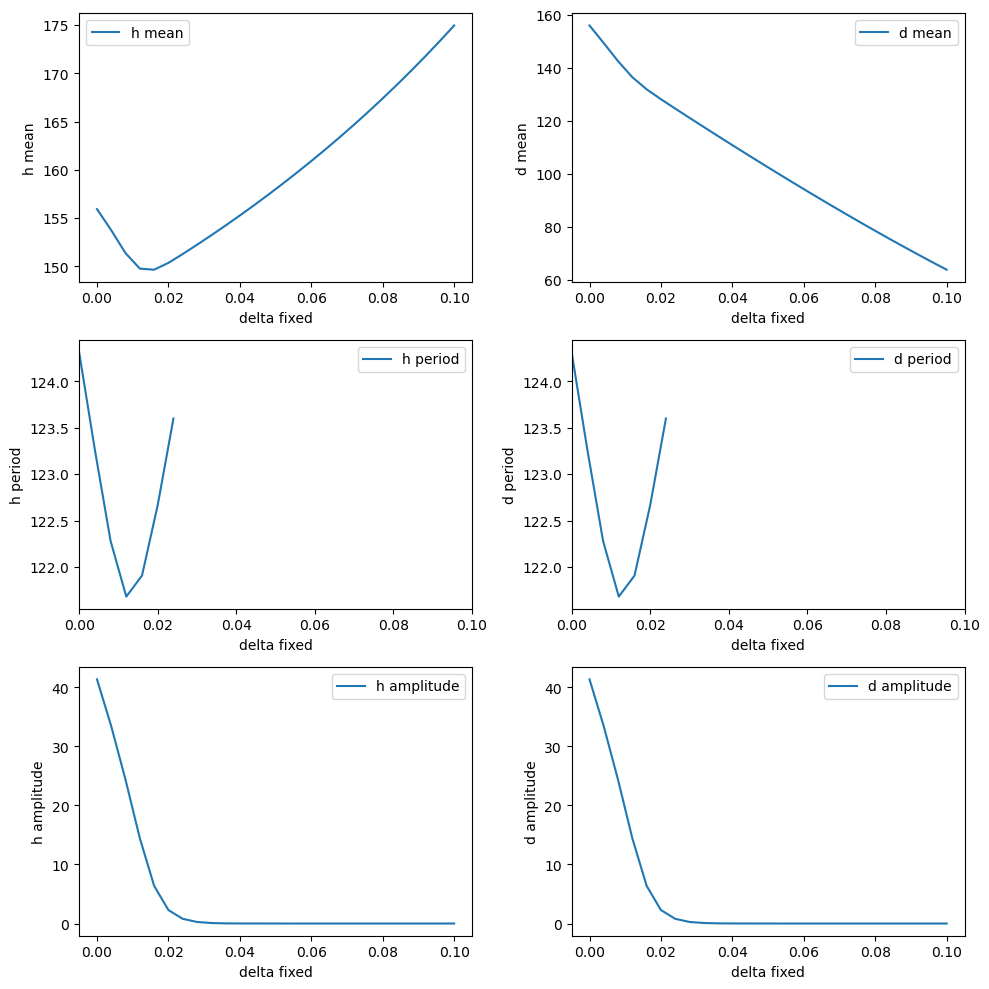

In [125]:
start_time = 10000

h_mean = np.mean(results_fixed[:,start_time:,0], axis=1)
d_mean = np.mean(results_fixed[:,start_time:,1], axis=1)

amplitude_h = np.zeros(len(delta_fixed))
amplitude_d = np.zeros(len(delta_fixed))
period_h = np.zeros(len(delta_fixed))
period_d = np.zeros(len(delta_fixed))

for i in range(len(delta_fixed)):
    amplitude_h[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,0])[0]
    amplitude_d[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,1])[0]

    amplitude_d = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
    amplitude_h = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

    if amplitude_h[i] > 0.5:
        period_h[i] = estimate_period_from_peaks(results_fixed[i,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_h[i] = None

    if amplitude_d[i] > 0.5:
        period_d[i] = estimate_period_from_peaks(results_fixed[i,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_d[i] = None

print(amplitude_h.shape)
print(amplitude_d)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(delta_fixed, h_mean, label='h mean')
plt.xlabel('delta fixed')
plt.ylabel('h mean')   
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(delta_fixed, d_mean, label='d mean')
plt.xlabel('delta fixed')
plt.ylabel('d mean')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(delta_fixed, period_h, label='h period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('h period')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(delta_fixed, period_d, label='d period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('d period')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(delta_fixed, amplitude_h, label='h amplitude')
plt.xlabel('delta fixed')
plt.ylabel('h amplitude')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(delta_fixed, amplitude_d, label='d amplitude')
plt.xlabel('delta fixed')
plt.ylabel('d amplitude')
plt.legend()
plt.tight_layout()

## Synchronicity between two cells

In [ ]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50

T_coupling = 0
w_h = 1
l = 5
n = 4

# the important parameters for this test
T_h = 0      # delay in Hes of first cell
delay_shift = 0 # difference in delay between the two cells

num_tsteps = 20000
dt = 0.2

In [123]:
#uncoupled periods: 
w_coupling = 0 

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = delay_shift, grad_coup_strength = 0)
h_uncoupled, m_h, d_uncoupled, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

#coupled periods 
w_coupling = 2
params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = delay_shift, grad_coup_strength = 0)
h_coupled, m_h, d_coupled, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

  0%|          | 0/19999 [00:00<?, ?it/s]

100%|██████████| 19999/19999 [00:09<00:00, 2152.94it/s]


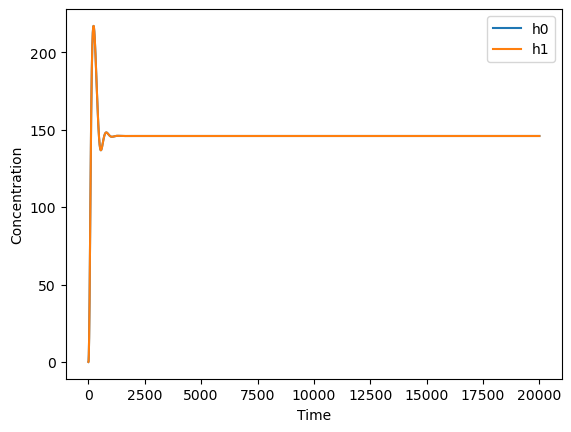

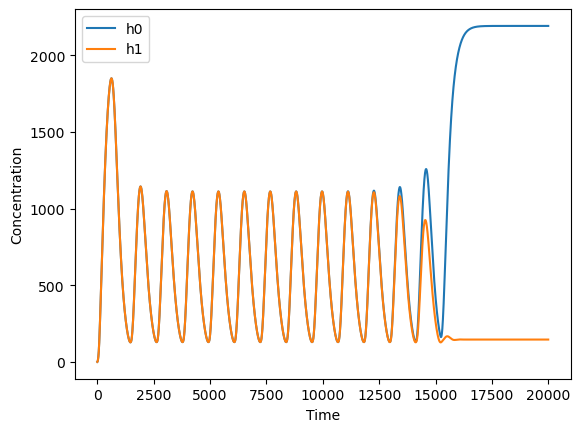

In [124]:
plt.plot(h_uncoupled[:,0,0], label = 'h0')
# plt.plot(d_uncoupled[:,0,0], label = 'd0')
plt.plot(h_uncoupled[:,1,0], label = 'h1')
# plt.plot(d_uncoupled[:,1,0], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

plt.figure()
plt.plot(h_coupled[:,0,0], label = 'h0')
# plt.plot(d_coupled[:,0,0], label = 'd0')
plt.plot(h_coupled[:,1,0], label = 'h1')
# plt.plot(d_coupled[:,1,0], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

In [113]:
#uncoupled periods: 
w_coupling = 0 

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = delay_shift, grad_coup_strength = 0)
h_uncoupled, m_h, d_uncoupled, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

#coupled periods 
w_coupling = 2
params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = delay_shift, grad_coup_strength = 0)
h_coupled, m_h, d_coupled, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

100%|██████████| 19999/19999 [00:02<00:00, 8440.24it/s]


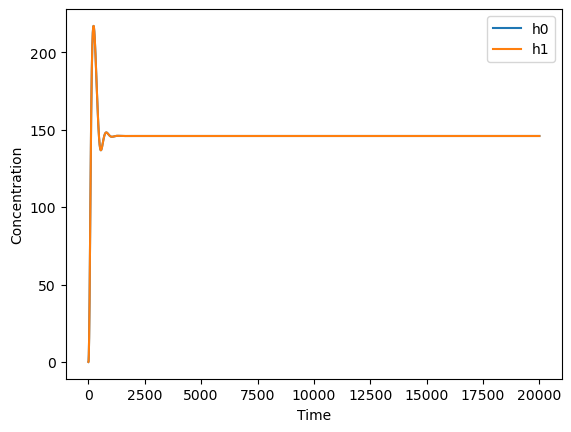

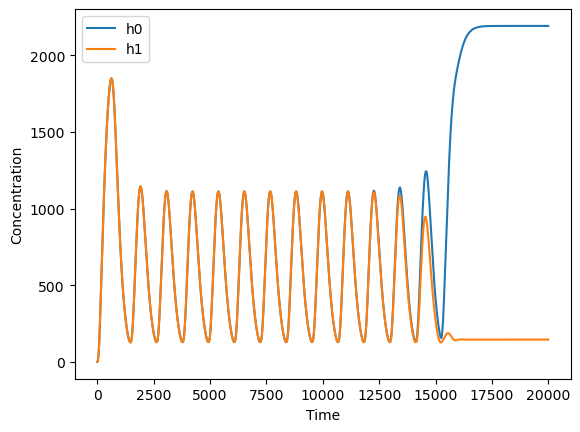

In [114]:
plt.plot(h_uncoupled[:,0,0], label = 'h0')
# plt.plot(d_uncoupled[:,0,0], label = 'd0')
plt.plot(h_uncoupled[:,1,0], label = 'h1')
# plt.plot(d_uncoupled[:,1,0], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

plt.figure()
plt.plot(h_coupled[:,0,0], label = 'h0')
# plt.plot(d_coupled[:,0,0], label = 'd0')
plt.plot(h_coupled[:,1,0], label = 'h1')
# plt.plot(d_coupled[:,1,0], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()